<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Copy_of_Yet_another_copy_of_Yet_another_copy_of_Hybrid_pmos-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [2]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.22,
    epochs=500,
    batch_size=160,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 55.3944
Epoch 1: val_loss improved from inf to 18.40261, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 54.8197 - val_loss: 18.4026
Epoch 2/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.5025 
Epoch 2: val_loss improved from 18.40261 to 13.13954, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.2109 - val_loss: 13.1395
Epoch 3/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.6966 
Epoch 3: val_loss improved from 13.13954 to 12.28149, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.5639 - val_loss: 12.2815
Epoch 4/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.3618 
Epoch 4: val_loss improved from 12.28149 to 11.66228, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4369 - val_loss: 11.6623
Epoch 5/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0729
Epoch 5: val_loss improved from 11.66228 to 11.38883, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.0864 - val_loss: 11.3888
Epoch 6/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1197 
Epoch 6: val_loss improved from 11.38883 to 10.73570, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.0316 - val_loss: 10.7357
Epoch 7/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.6491
Epoch 7: val_loss improved from 10.73570 to 10.33518, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5684 - val_loss: 10.3352
Epoch 8/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0210
Epoch 8: val_loss improved from 10.33518 to 9.68480, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9704 - val_loss: 9.6848
Epoch 9/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7928 
Epoch 9: val_loss improved from 9.68480 to 8.99079, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7022 - val_loss: 8.9908
Epoch 10/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0194 
Epoch 10: val_loss improved from 8.99079 to 8.31073, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9137 - val_loss: 8.3107
Epoch 11/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7071 
Epoch 11: val_loss improved from 8.31073 to 6.81710, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6926 - val_loss: 6.8171
Epoch 12/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8833 
Epoch 12: val_loss improved from 6.81710 to 5.49514, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8075 - val_loss: 5.4951
Epoch 13/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6762 
Epoch 13: val_loss improved from 5.49514 to 4.46443, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6340 - val_loss: 4.4644
Epoch 14/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6807 
Epoch 14: val_loss improved from 4.46443 to 3.97450, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6449 - val_loss: 3.9745
Epoch 15/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3157 
Epoch 15: val_loss improved from 3.97450 to 3.67252, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3108 - val_loss: 3.6725
Epoch 16/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1611 
Epoch 16: val_loss improved from 3.67252 to 3.47641, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1323 - val_loss: 3.4764
Epoch 17/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7473 
Epoch 17: val_loss improved from 3.47641 to 3.46992, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7789 - val_loss: 3.4699
Epoch 18/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9901 
Epoch 18: val_loss did not improve from 3.46992
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9569 - val_loss: 3.5452
Epoch 19/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8249 
Epoch 19: val_loss improved from 3.46992 to 3.17533, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7776 - val_loss: 3.1753
Epoch 20/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3887 
Epoch 20: val_loss did not improve from 3.17533
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4071 - val_loss: 3.3165
Epoch 21/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6233 
Epoch 21: val_loss improved from 3.17533 to 2.92501, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5835 - val_loss: 2.9250
Epoch 22/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3072 
Epoch 22: val_loss improved from 2.92501 to 2.83856, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3082 - val_loss: 2.8386
Epoch 23/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3356 
Epoch 23: val_loss improved from 2.83856 to 2.76867, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2978 - val_loss: 2.7687
Epoch 24/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8182 
Epoch 24: val_loss improved from 2.76867 to 2.75488, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8614 - val_loss: 2.7549
Epoch 25/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7371 
Epoch 25: val_loss improved from 2.75488 to 2.59127, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7847 - val_loss: 2.5913
Epoch 26/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8960 
Epoch 26: val_loss did not improve from 2.59127
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8820 - val_loss: 2.6113
Epoch 27/500
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7604 
Epoch 27: val_loss improved from 2.59127 to 2.47093, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7632 - val_loss: 2.4709
Epoch 28/500
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6670 
Epoch 28: val_loss improved from 2.47093 to 2.37126, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6602 - val_loss: 2.3713
Epoch 29/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3855 
Epoch 29: val_loss improved from 2.37126 to 2.21913, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4095 - val_loss: 2.2191
Epoch 30/500
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5229 
Epoch 30: val_loss improved from 2.21913 to 2.21130, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5088 - val_loss: 2.2113
Epoch 31/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2268 
Epoch 31: val_loss improved from 2.21130 to 2.11921, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2507 - val_loss: 2.1192
Epoch 32/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5965 
Epoch 32: val_loss did not improve from 2.11921
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5565 - val_loss: 2.1370
Epoch 33/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6206 
Epoch 33: val_loss improved from 2.11921 to 1.96555, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5481 - val_loss: 1.9656
Epoch 34/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9978 
Epoch 34: val_loss improved from 1.96555 to 1.88931, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0097 - val_loss: 1.8893
Epoch 35/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0513 
Epoch 35: val_loss improved from 1.88931 to 1.77119, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0556 - val_loss: 1.7712
Epoch 36/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9940 
Epoch 36: val_loss did not improve from 1.77119
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9833 - val_loss: 1.8913
Epoch 37/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0602 
Epoch 37: val_loss did not improve from 1.77119
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0393 - val_loss: 1.7900
Epoch 38/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8578 
Epoch 38: val_loss did not improve from 1.77119
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8435 - val_loss: 1.8164
Epoch 39/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7373 
Epoch 39: val_loss improved from 1.77119 to 1.49852, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7458 - val_loss: 1.4985
Epoch 40/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6201 
Epoch 40: val_loss did not improve from 1.49852
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6210 - val_loss: 1.5013
Epoch 41/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5893 
Epoch 41: val_loss did not improve from 1.49852
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5951 - val_loss: 1.5569
Epoch 42/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5008 
Epoch 42: val_loss improved from 1.49852 to 1.41276, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4969 - val_loss: 1.4128
Epoch 43/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4531 
Epoch 43: val_loss did not improve from 1.41276
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4628 - val_loss: 1.6116
Epoch 44/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5138 
Epoch 44: val_loss improved from 1.41276 to 1.30639, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5160 - val_loss: 1.3064
Epoch 45/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3575 
Epoch 45: val_loss did not improve from 1.30639
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3619 - val_loss: 1.3657
Epoch 46/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2764 
Epoch 46: val_loss improved from 1.30639 to 1.24223, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2651 - val_loss: 1.2422
Epoch 47/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3069 
Epoch 47: val_loss did not improve from 1.24223
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2965 - val_loss: 1.6269
Epoch 48/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3077 
Epoch 48: val_loss did not improve from 1.24223
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2952 - val_loss: 1.3747
Epoch 49/500
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1887 
Epoch 49: val_loss did not improve from 1.24223
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1807 - val_loss: 1.2737
Epoch 50/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0196 
Epoch 50: val_loss did not improve from 1.24223
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0378 - val_loss: 1.2633
Epoch 51/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1288 
Epoch 51: val_loss did not improve from 1.24223
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1308 -

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1409 - val_loss: 0.9885
Epoch 53/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9416 
Epoch 53: val_loss did not improve from 0.98848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9463 - val_loss: 1.3532
Epoch 54/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1850 
Epoch 54: val_loss did not improve from 0.98848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1483 - val_loss: 1.3927
Epoch 55/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0195 
Epoch 55: val_loss improved from 0.98848 to 0.94422, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0291 - val_loss: 0.9442
Epoch 56/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7910 
Epoch 56: val_loss did not improve from 0.94422
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8065 - val_loss: 1.2200
Epoch 57/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1141 
Epoch 57: val_loss improved from 0.94422 to 0.90382, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1153 - val_loss: 0.9038
Epoch 58/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8405 
Epoch 58: val_loss improved from 0.90382 to 0.77361, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8296 - val_loss: 0.7736
Epoch 59/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7292 
Epoch 59: val_loss improved from 0.77361 to 0.70182, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7169 - val_loss: 0.7018
Epoch 60/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 
Epoch 60: val_loss improved from 0.70182 to 0.64623, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6268 - val_loss: 0.6462
Epoch 61/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6312 
Epoch 61: val_loss did not improve from 0.64623
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6422 - val_loss: 0.8346
Epoch 62/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6097 
Epoch 62: val_loss did not improve from 0.64623
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6042 - val_loss: 0.6906
Epoch 63/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6124 
Epoch 63: val_loss did not improve from 0.64623
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6308 - val_loss: 1.3756
Epoch 64/500
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0386 
Epoch 64: val_loss did not improve from 0.64623
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0461 - val_loss: 2.0760
Epoch 65/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5933 
Epoch 65: val_loss improved from 0.64623 to 0.61301, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4878 - val_loss: 0.6130
Epoch 66/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5747 
Epoch 66: val_loss improved from 0.61301 to 0.59234, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5732 - val_loss: 0.5923
Epoch 67/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6207 
Epoch 67: val_loss improved from 0.59234 to 0.56974, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6267 - val_loss: 0.5697
Epoch 68/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9339 
Epoch 68: val_loss did not improve from 0.56974
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9066 - val_loss: 0.6408
Epoch 69/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5114 
Epoch 69: val_loss did not improve from 0.56974
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5158 - val_loss: 0.7537
Epoch 70/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9177 
Epoch 70: val_loss did not improve from 0.56974
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8823 - val_loss: 0.5746
Epoch 71/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5084 
Epoch 71: val_loss did not improve from 0.56974
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4977 - val_loss: 0.6982
Epoch 72/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6323 
Epoch 72: val_loss did not improve from 0.56974
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6401 -

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6097 - val_loss: 0.5181
Epoch 74/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4266 
Epoch 74: val_loss did not improve from 0.51808
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4253 - val_loss: 0.6199
Epoch 75/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5038 
Epoch 75: val_loss improved from 0.51808 to 0.48158, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4916 - val_loss: 0.4816
Epoch 76/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5090 
Epoch 76: val_loss did not improve from 0.48158
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5075 - val_loss: 0.5707
Epoch 77/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4353 
Epoch 77: val_loss improved from 0.48158 to 0.46520, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4255 - val_loss: 0.4652
Epoch 78/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3784 
Epoch 78: val_loss improved from 0.46520 to 0.35490, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3871 - val_loss: 0.3549
Epoch 79/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3514 
Epoch 79: val_loss did not improve from 0.35490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3487 - val_loss: 0.4034
Epoch 80/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3149 
Epoch 80: val_loss did not improve from 0.35490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3200 - val_loss: 0.6050
Epoch 81/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4326 
Epoch 81: val_loss improved from 0.35490 to 0.33008, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4214 - val_loss: 0.3301
Epoch 82/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5657 
Epoch 82: val_loss did not improve from 0.33008
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5528 - val_loss: 0.6223
Epoch 83/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4449 
Epoch 83: val_loss did not improve from 0.33008
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4484 - val_loss: 0.6173
Epoch 84/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4484 
Epoch 84: val_loss did not improve from 0.33008
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4412 - val_loss: 0.3851
Epoch 85/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2902 
Epoch 85: val_loss did not improve from 0.33008
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2921 - val_loss: 0.3511
Epoch 86/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3952 
Epoch 86: val_loss did not improve from 0.33008
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4122 -

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3717 - val_loss: 0.3130
Epoch 90/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2934 
Epoch 90: val_loss improved from 0.31297 to 0.29206, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2910 - val_loss: 0.2921
Epoch 91/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2899 
Epoch 91: val_loss did not improve from 0.29206
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2948 - val_loss: 0.3713
Epoch 92/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2693 
Epoch 92: val_loss improved from 0.29206 to 0.26341, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2675 - val_loss: 0.2634
Epoch 93/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2264 
Epoch 93: val_loss improved from 0.26341 to 0.26205, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2295 - val_loss: 0.2620
Epoch 94/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2693 
Epoch 94: val_loss improved from 0.26205 to 0.25240, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2697 - val_loss: 0.2524
Epoch 95/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2473 
Epoch 95: val_loss did not improve from 0.25240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2477 - val_loss: 0.2633
Epoch 96/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2264 
Epoch 96: val_loss did not improve from 0.25240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2266 - val_loss: 0.3209
Epoch 97/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2666 
Epoch 97: val_loss did not improve from 0.25240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2660 - val_loss: 0.3485
Epoch 98/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2546 
Epoch 98: val_loss did not improve from 0.25240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2487 - val_loss: 0.3339
Epoch 99/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4045 
Epoch 99: val_loss did not improve from 0.25240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4556 -

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4662 - val_loss: 0.2372
Epoch 101/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2429 
Epoch 101: val_loss improved from 0.23717 to 0.22177, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2401 - val_loss: 0.2218
Epoch 102/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2057 
Epoch 102: val_loss improved from 0.22177 to 0.21646, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2066 - val_loss: 0.2165
Epoch 103/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2136 
Epoch 103: val_loss improved from 0.21646 to 0.21327, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2120 - val_loss: 0.2133
Epoch 104/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2009 
Epoch 104: val_loss did not improve from 0.21327
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2028 - val_loss: 0.2188
Epoch 105/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2020 
Epoch 105: val_loss did not improve from 0.21327
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2074 - val_loss: 0.2425
Epoch 106/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2516 
Epoch 106: val_loss did not improve from 0.21327
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2453 - val_loss: 0.2161
Epoch 107/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2057 
Epoch 107: val_loss improved from 0.21327 to 0.20338, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2033 - val_loss: 0.2034
Epoch 108/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2146 
Epoch 108: val_loss did not improve from 0.20338
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2180 - val_loss: 0.2139
Epoch 109/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2201 
Epoch 109: val_loss did not improve from 0.20338
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2218 - val_loss: 0.2609
Epoch 110/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1968 
Epoch 110: val_loss improved from 0.20338 to 0.19866, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1959 - val_loss: 0.1987
Epoch 111/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2000 
Epoch 111: val_loss did not improve from 0.19866
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1980 - val_loss: 0.2301
Epoch 112/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1964 
Epoch 112: val_loss improved from 0.19866 to 0.19418, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1952 - val_loss: 0.1942
Epoch 113/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2032 
Epoch 113: val_loss did not improve from 0.19418
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2034 - val_loss: 0.2007
Epoch 114/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1893 
Epoch 114: val_loss did not improve from 0.19418
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1886 - val_loss: 0.2044
Epoch 115/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1882 
Epoch 115: val_loss did not improve from 0.19418
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1920 - val_loss: 0.1958
Epoch 116/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2551 
Epoch 116: val_loss did not improve from 0.19418
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2482 - val_loss: 0.2220
Epoch 117/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2304 
Epoch 117: val_loss did not improve from 0.19418
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2275 - val_loss: 0.1835
Epoch 119/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1948 
Epoch 119: val_loss did not improve from 0.18350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1948 - val_loss: 0.2021
Epoch 120/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2242 
Epoch 120: val_loss did not improve from 0.18350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2238 - val_loss: 0.2747
Epoch 121/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2791 
Epoch 121: val_loss did not improve from 0.18350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2777 - val_loss: 0.2914
Epoch 122/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3830 
Epoch 122: val_loss did not improve from 0.18350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3818 - val_loss: 0.3010
Epoch 123/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3238 
Epoch 123: val_loss did not improve from 0.18350
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2063 - val_loss: 0.1816
Epoch 127/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1741 
Epoch 127: val_loss did not improve from 0.18156
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1745 - val_loss: 0.1874
Epoch 128/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1821 
Epoch 128: val_loss did not improve from 0.18156
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1808 - val_loss: 0.1845
Epoch 129/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1865 
Epoch 129: val_loss improved from 0.18156 to 0.17705, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1849 - val_loss: 0.1770
Epoch 130/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1717 
Epoch 130: val_loss did not improve from 0.17705
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1720 - val_loss: 0.1802
Epoch 131/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1766 
Epoch 131: val_loss improved from 0.17705 to 0.17247, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1761 - val_loss: 0.1725
Epoch 132/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1772 
Epoch 132: val_loss did not improve from 0.17247
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1769 - val_loss: 0.1854
Epoch 133/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1708 
Epoch 133: val_loss improved from 0.17247 to 0.17132, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1709 - val_loss: 0.1713
Epoch 134/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1711 
Epoch 134: val_loss did not improve from 0.17132
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1727 - val_loss: 0.2330
Epoch 135/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2113 
Epoch 135: val_loss did not improve from 0.17132
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2045 - val_loss: 0.1767
Epoch 136/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1691 
Epoch 136: val_loss did not improve from 0.17132
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1693 - val_loss: 0.1868
Epoch 137/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1816 
Epoch 137: val_loss improved from 0.17132 to 0.16490, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1786 - val_loss: 0.1649
Epoch 138/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1742 
Epoch 138: val_loss did not improve from 0.16490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1759 - val_loss: 0.1813
Epoch 139/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1944 
Epoch 139: val_loss did not improve from 0.16490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1910 - val_loss: 0.2040
Epoch 140/500
25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1702 
Epoch 140: val_loss did not improve from 0.16490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1730 - val_loss: 0.2567
Epoch 141/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2770 
Epoch 141: val_loss did not improve from 0.16490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2610 - val_loss: 0.1711
Epoch 142/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1753 
Epoch 142: val_loss did not improve from 0.16490
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1756 - val_loss: 0.1625
Epoch 146/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1607 
Epoch 146: val_loss improved from 0.16247 to 0.15967, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1602 - val_loss: 0.1597
Epoch 147/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1644 
Epoch 147: val_loss did not improve from 0.15967
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1648 - val_loss: 0.1602
Epoch 148/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1566 
Epoch 148: val_loss did not improve from 0.15967
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1760
Epoch 149/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596 
Epoch 149: val_loss improved from 0.15967 to 0.15827, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1603 - val_loss: 0.1583
Epoch 150/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1655 
Epoch 150: val_loss did not improve from 0.15827
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1646 - val_loss: 0.1616
Epoch 151/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1565 
Epoch 151: val_loss improved from 0.15827 to 0.15511, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1572 - val_loss: 0.1551
Epoch 152/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1640 
Epoch 152: val_loss did not improve from 0.15511
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1706 - val_loss: 0.2094
Epoch 153/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 
Epoch 153: val_loss did not improve from 0.15511
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1837 - val_loss: 0.1783
Epoch 154/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 
Epoch 154: val_loss did not improve from 0.15511
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1919 - val_loss: 0.1632
Epoch 155/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1545 
Epoch 155: val_loss did not improve from 0.15511
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561 - val_loss: 0.1882
Epoch 156/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1655 
Epoch 156: val_loss did not improve from 0.15511
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1558 - val_loss: 0.1551
Epoch 179/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1607 
Epoch 179: val_loss did not improve from 0.15507
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1598 - val_loss: 0.1584
Epoch 180/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1556 
Epoch 180: val_loss did not improve from 0.15507
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1554 - val_loss: 0.1573
Epoch 181/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 181: val_loss did not improve from 0.15507
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1558 - val_loss: 0.1578
Epoch 182/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1537 
Epoch 182: val_loss did not improve from 0.15507
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1538 - val_loss: 0.1556
Epoch 183/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1508 
Epoch 183: val_loss improved from 0.15507 to 0.15472, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1518 - val_loss: 0.1547
Epoch 184/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1522 
Epoch 184: val_loss improved from 0.15472 to 0.15364, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1534 - val_loss: 0.1536
Epoch 185/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 
Epoch 185: val_loss improved from 0.15364 to 0.15139, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1474 - val_loss: 0.1514
Epoch 186/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1467 
Epoch 186: val_loss did not improve from 0.15139
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1483 - val_loss: 0.1626
Epoch 187/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1565 
Epoch 187: val_loss did not improve from 0.15139
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1560 - val_loss: 0.1641
Epoch 188/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1516 
Epoch 188: val_loss did not improve from 0.15139
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1518 - val_loss: 0.1535
Epoch 189/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1518 
Epoch 189: val_loss did not improve from 0.15139
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1519 - val_loss: 0.1536
Epoch 190/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1644 
Epoch 190: val_loss improved from 0.15139 to 0.14798, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1627 - val_loss: 0.1480
Epoch 191/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1439 
Epoch 191: val_loss did not improve from 0.14798
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1452 - val_loss: 0.1509
Epoch 192/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 192: val_loss did not improve from 0.14798
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1505 - val_loss: 0.1508
Epoch 193/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1632 
Epoch 193: val_loss did not improve from 0.14798
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1618 - val_loss: 0.1617
Epoch 194/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1430 
Epoch 194: val_loss did not improve from 0.14798
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1445 - val_loss: 0.1632
Epoch 195/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 
Epoch 195: val_loss did not improve from 0.14798
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1533 - val_loss: 0.1462
Epoch 206/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 
Epoch 206: val_loss did not improve from 0.14622
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1552 - val_loss: 0.1490
Epoch 207/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 207: val_loss improved from 0.14622 to 0.14600, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1511 - val_loss: 0.1460
Epoch 208/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1569 
Epoch 208: val_loss did not improve from 0.14600
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1560 - val_loss: 0.1573
Epoch 209/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 
Epoch 209: val_loss did not improve from 0.14600
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1472 - val_loss: 0.1470
Epoch 210/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1376 
Epoch 210: val_loss did not improve from 0.14600
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.1481
Epoch 211/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1408 
Epoch 211: val_loss improved from 0.14600 to 0.14348, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1425 - val_loss: 0.1435
Epoch 212/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1543 
Epoch 212: val_loss did not improve from 0.14348
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1527 - val_loss: 0.1457
Epoch 213/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1463 
Epoch 213: val_loss did not improve from 0.14348
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1460 - val_loss: 0.1498
Epoch 214/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1597 
Epoch 214: val_loss did not improve from 0.14348
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1792
Epoch 215/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1599 
Epoch 215: val_loss did not improve from 0.14348
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.2490
Epoch 216/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2207 
Epoch 216: val_loss did not improve from 0.14348
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1432 - val_loss: 0.1435
Epoch 257/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1504 
Epoch 257: val_loss did not improve from 0.14347
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1491 - val_loss: 0.1614
Epoch 258/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1606 
Epoch 258: val_loss did not improve from 0.14347
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1605 - val_loss: 0.1492
Epoch 259/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1487 
Epoch 259: val_loss did not improve from 0.14347
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1485 - val_loss: 0.1499
Epoch 260/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1523 
Epoch 260: val_loss did not improve from 0.14347
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1524 - val_loss: 0.1583
Epoch 261/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1549 
Epoch 261: val_loss did not improve from 0.14347
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1479 - val_loss: 0.1432
Epoch 263/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 263: val_loss did not improve from 0.14320
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1501 - val_loss: 0.1861
Epoch 264/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1762 
Epoch 264: val_loss did not improve from 0.14320
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1733 - val_loss: 0.1461
Epoch 265/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1479 
Epoch 265: val_loss did not improve from 0.14320
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1490 - val_loss: 0.1452
Epoch 266/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1587 
Epoch 266: val_loss improved from 0.14320 to 0.14274, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1557 - val_loss: 0.1427
Epoch 267/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 267: val_loss improved from 0.14274 to 0.14137, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1402 - val_loss: 0.1414
Epoch 268/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1370 
Epoch 268: val_loss did not improve from 0.14137
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1384 - val_loss: 0.1430
Epoch 269/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 269: val_loss did not improve from 0.14137
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1401 - val_loss: 0.1416
Epoch 270/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 270: val_loss did not improve from 0.14137
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1416
Epoch 271/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 
Epoch 271: val_loss did not improve from 0.14137
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404 - val_loss: 0.1460
Epoch 272/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1456 
Epoch 272: val_loss did not improve from 0.14137
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1416 - val_loss: 0.1409
Epoch 296/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440 
Epoch 296: val_loss did not improve from 0.14089
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1433 - val_loss: 0.1418
Epoch 297/500
26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1487 
Epoch 297: val_loss did not improve from 0.14089
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477 - val_loss: 0.1450
Epoch 298/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1462 
Epoch 298: val_loss did not improve from 0.14089
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1463 - val_loss: 0.1432
Epoch 299/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1573 
Epoch 299: val_loss improved from 0.14089 to 0.14011, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1539 - val_loss: 0.1401
Epoch 300/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 
Epoch 300: val_loss did not improve from 0.14011
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1419 - val_loss: 0.1412
Epoch 301/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1410 
Epoch 301: val_loss did not improve from 0.14011
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1413
Epoch 302/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 302: val_loss did not improve from 0.14011
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1412
Epoch 303/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1390 
Epoch 303: val_loss did not improve from 0.14011
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1402
Epoch 304/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1465 
Epoch 304: val_loss did not improve from 0.14011
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358 - val_loss: 0.1396
Epoch 308/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 308: val_loss did not improve from 0.13958
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404 - val_loss: 0.1400
Epoch 309/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1386 
Epoch 309: val_loss did not improve from 0.13958
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1385 - val_loss: 0.1416
Epoch 310/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346 
Epoch 310: val_loss did not improve from 0.13958
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1357 - val_loss: 0.1401
Epoch 311/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1467 
Epoch 311: val_loss did not improve from 0.13958
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1464 - val_loss: 0.1409
Epoch 312/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1369 
Epoch 312: val_loss improved from 0.13958 to 0.13916, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1367 - val_loss: 0.1392
Epoch 313/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 313: val_loss did not improve from 0.13916
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1426 - val_loss: 0.1405
Epoch 314/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 314: val_loss did not improve from 0.13916
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1418
Epoch 315/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1435 
Epoch 315: val_loss did not improve from 0.13916
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1432 - val_loss: 0.1395
Epoch 316/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1455 
Epoch 316: val_loss did not improve from 0.13916
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1444 - val_loss: 0.1404
Epoch 317/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1419 
Epoch 317: val_loss did not improve from 0.13916
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1348 - val_loss: 0.1385
Epoch 320/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 320: val_loss did not improve from 0.13848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1403
Epoch 321/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411 
Epoch 321: val_loss did not improve from 0.13848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1417 - val_loss: 0.1428
Epoch 322/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 
Epoch 322: val_loss did not improve from 0.13848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1439 - val_loss: 0.1390
Epoch 323/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1407 
Epoch 323: val_loss did not improve from 0.13848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1408 - val_loss: 0.1404
Epoch 324/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 324: val_loss did not improve from 0.13848
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1382
Epoch 363/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 363: val_loss improved from 0.13817 to 0.13747, saving model to best_final_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1421 - val_loss: 0.1375
Epoch 364/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 364: val_loss did not improve from 0.13747
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1389
Epoch 365/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Epoch 365: val_loss did not improve from 0.13747
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1349 - val_loss: 0.1381
Epoch 366/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 366: val_loss did not improve from 0.13747
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1419 - val_loss: 0.1405
Epoch 367/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1389 
Epoch 367: val_loss did not improve from 0.13747
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1390
Epoch 368/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1464 
Epoch 368: val_loss did not improve from 0.13747
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1432 - val_loss: 0.1368
Epoch 371/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1428 
Epoch 371: val_loss did not improve from 0.13681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1415 - val_loss: 0.1437
Epoch 372/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 
Epoch 372: val_loss did not improve from 0.13681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1376
Epoch 373/500
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1408 
Epoch 373: val_loss did not improve from 0.13681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1403 - val_loss: 0.1373
Epoch 374/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1407 
Epoch 374: val_loss did not improve from 0.13681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1406 - val_loss: 0.1435
Epoch 375/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 375: val_loss did not improve from 0.13681
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1465 - val_loss: 0.1366
Epoch 392/500
27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 
Epoch 392: val_loss did not improve from 0.13663
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1494
Epoch 393/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1428 
Epoch 393: val_loss did not improve from 0.13663
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1426 - val_loss: 0.1379
Epoch 394/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483 
Epoch 394: val_loss did not improve from 0.13663
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1465 - val_loss: 0.1374
Epoch 395/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1438 
Epoch 395: val_loss did not improve from 0.13663
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1397
Epoch 396/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1529 
Epoch 396: val_loss did not improve from 0.13663
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1418 - val_loss: 0.1350
Epoch 413/500
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1353 
Epoch 413: val_loss did not improve from 0.13499
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1359 - val_loss: 0.1398
Epoch 414/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1353 
Epoch 414: val_loss did not improve from 0.13499
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1366 - val_loss: 0.1376
Epoch 415/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1275 
Epoch 415: val_loss did not improve from 0.13499
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1294 - val_loss: 0.1362
Epoch 416/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 
Epoch 416: val_loss did not improve from 0.13499
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1411 - val_loss: 0.1359
Epoch 417/500
29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1445 
Epoch 417: val_loss did not improve from 0.13499
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [6]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Final NN I_ds → MSE: 3.2224e-11, R²: 0.9992
Final gm → MSE: 1.2415e-11, R²: 0.9993
Final gd → MSE: 4.2861e-11, R²: 0.9970


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


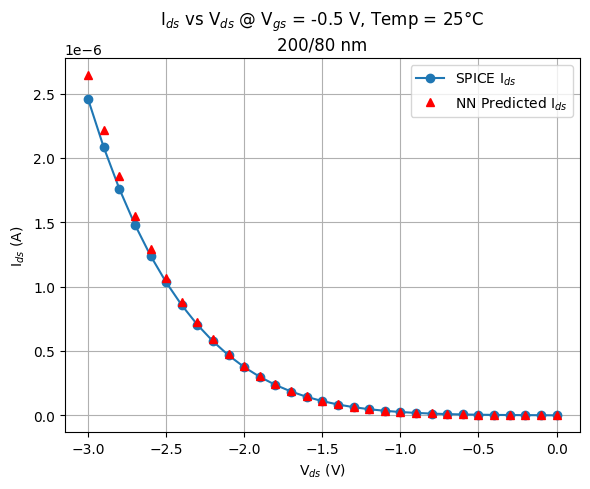

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


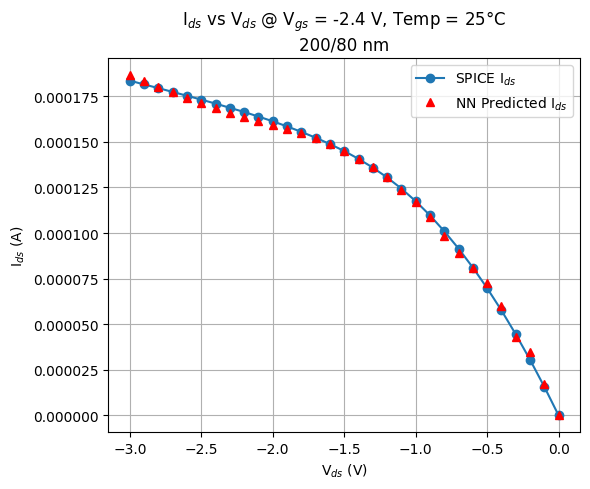

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


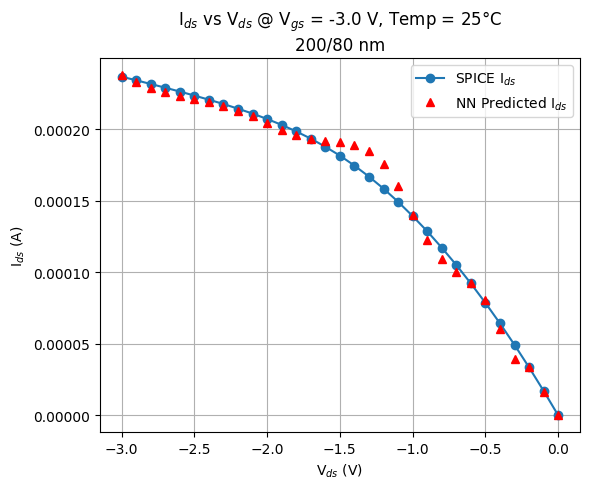

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


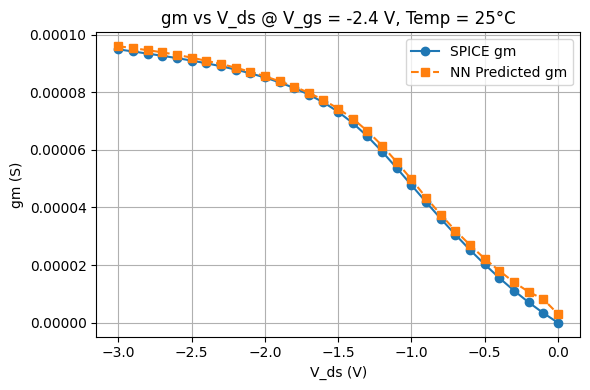

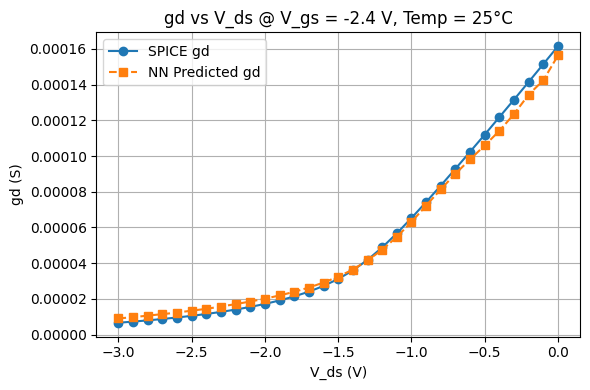

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'device_signatures' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


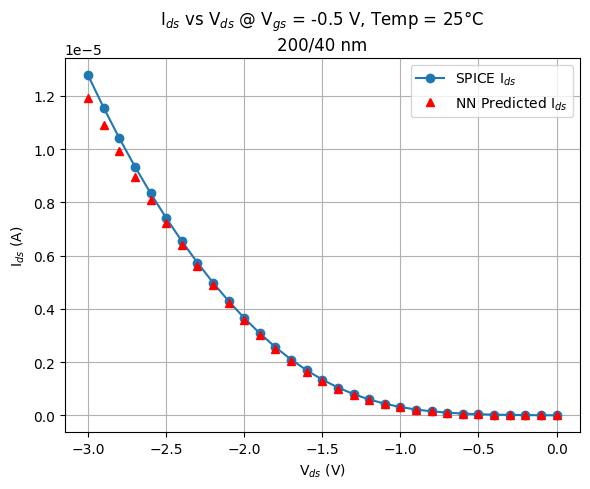

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


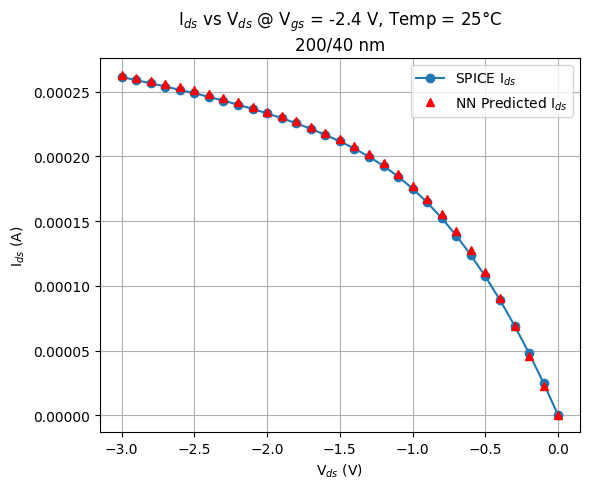

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


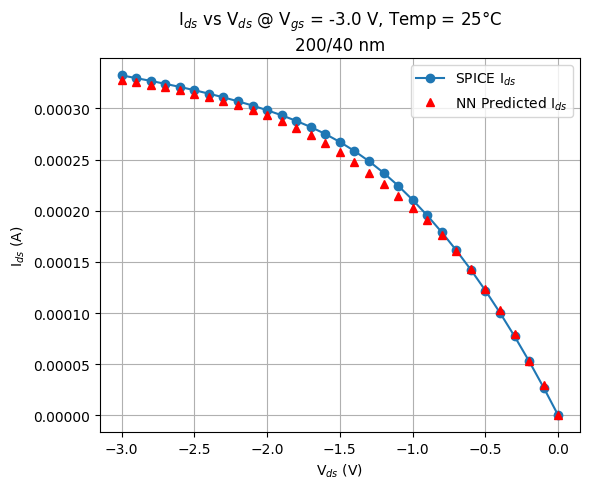

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


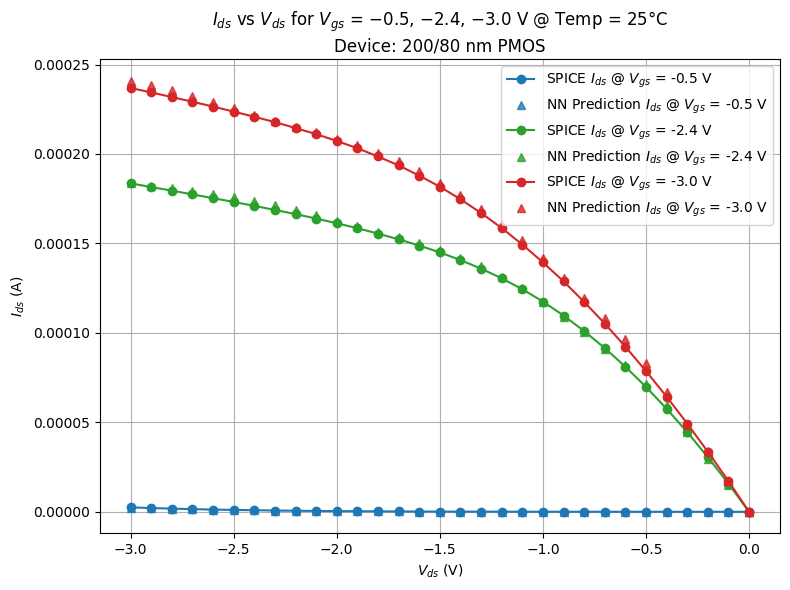

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


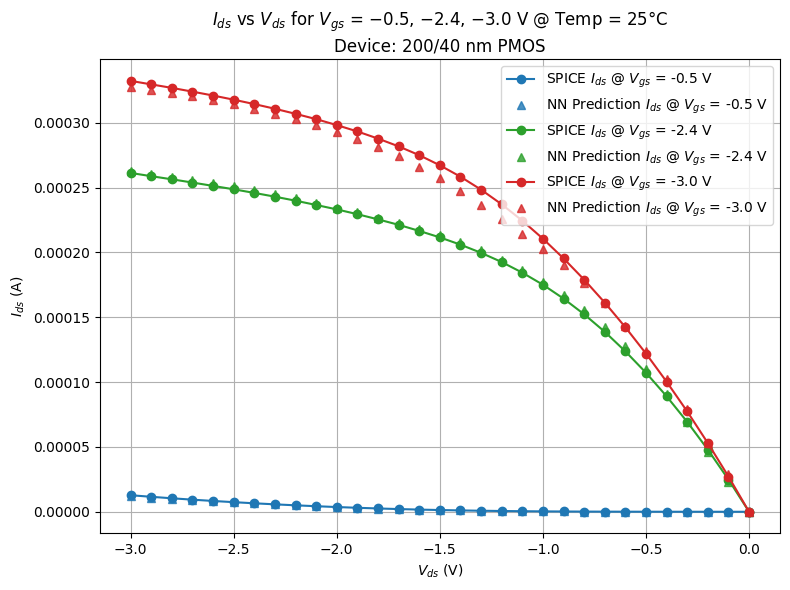

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


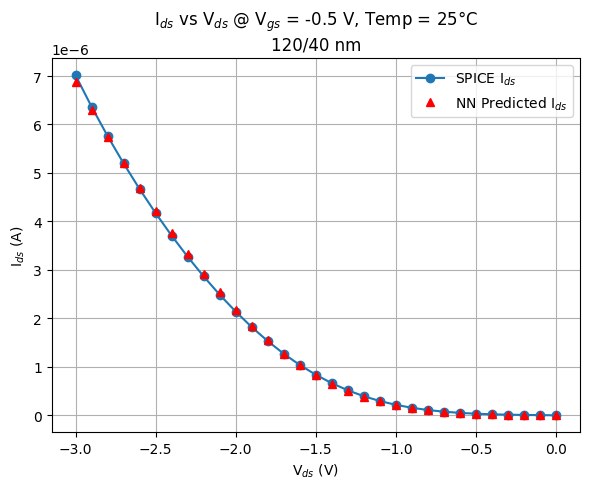

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


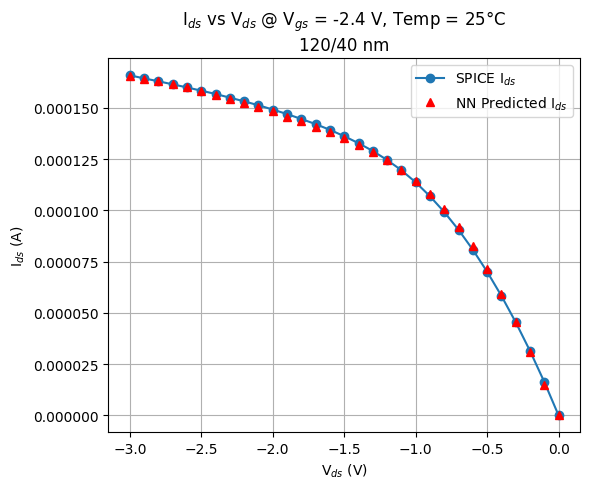

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


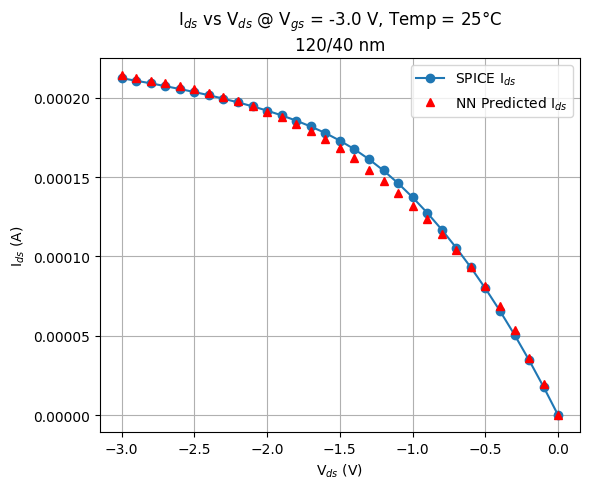

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


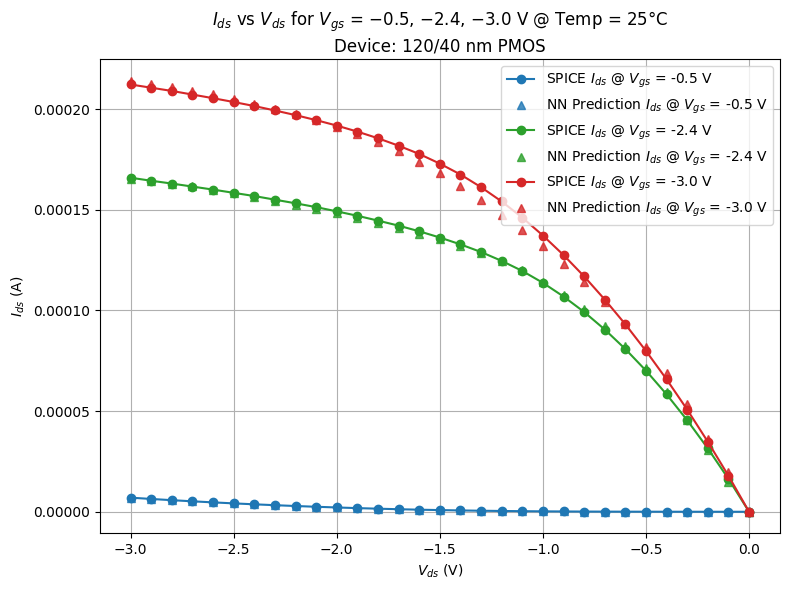

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


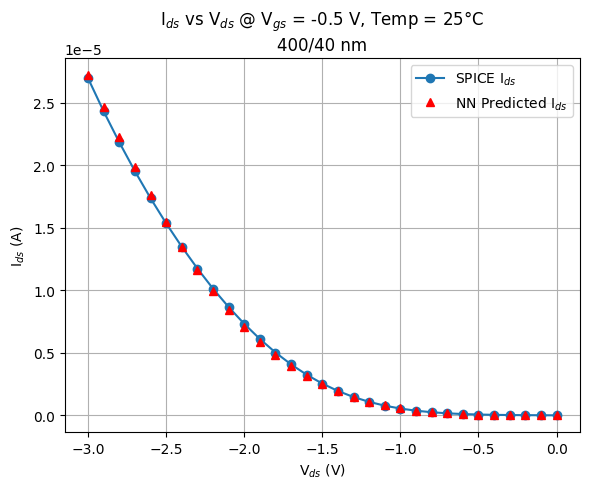

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


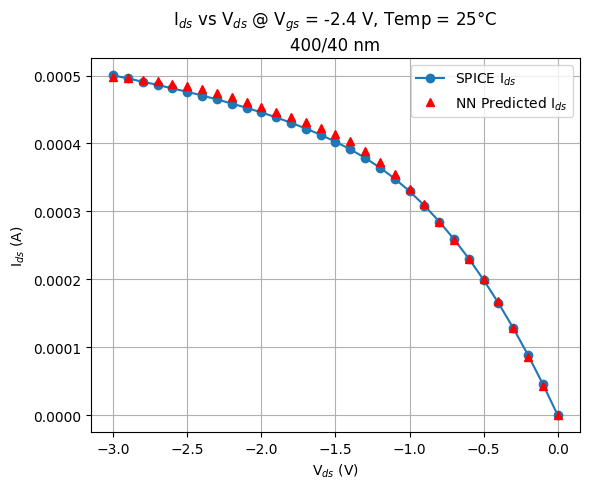

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


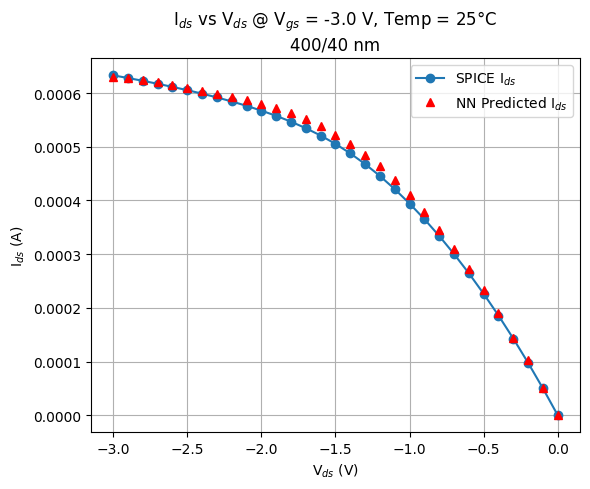

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


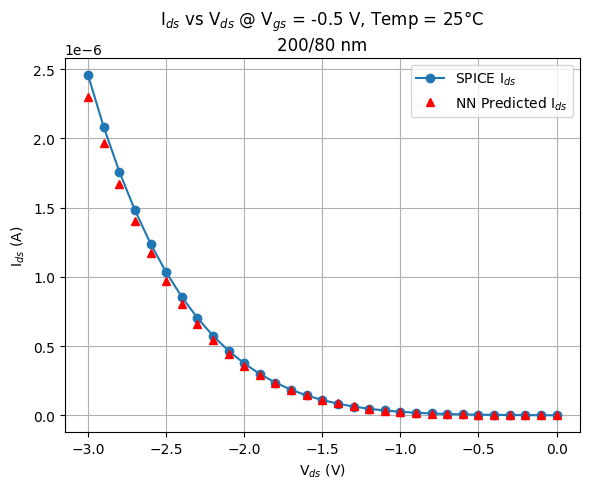

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


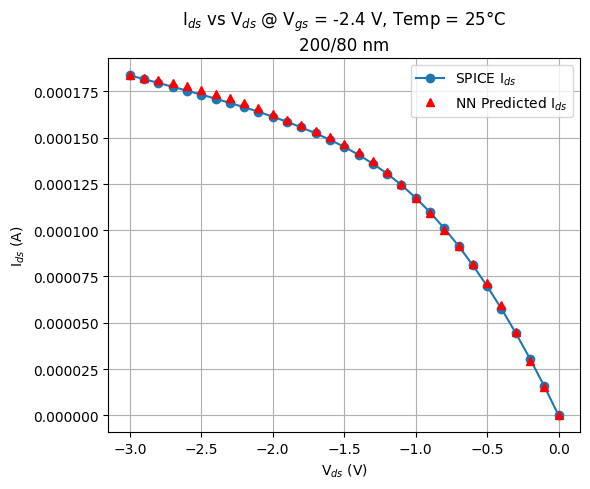

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


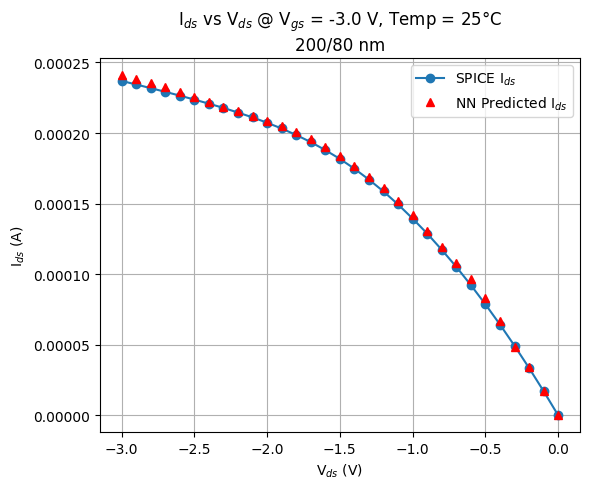

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


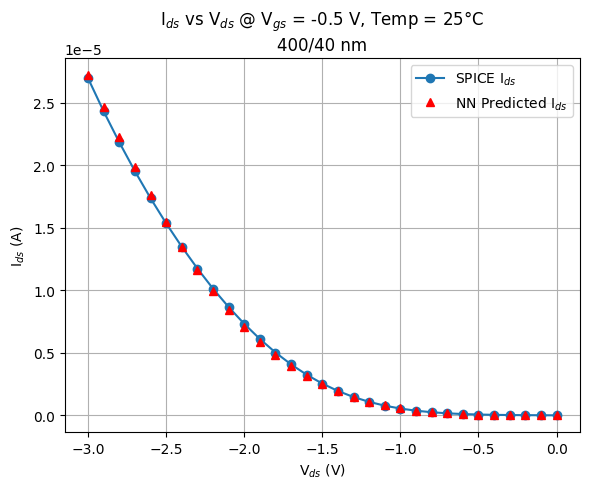

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


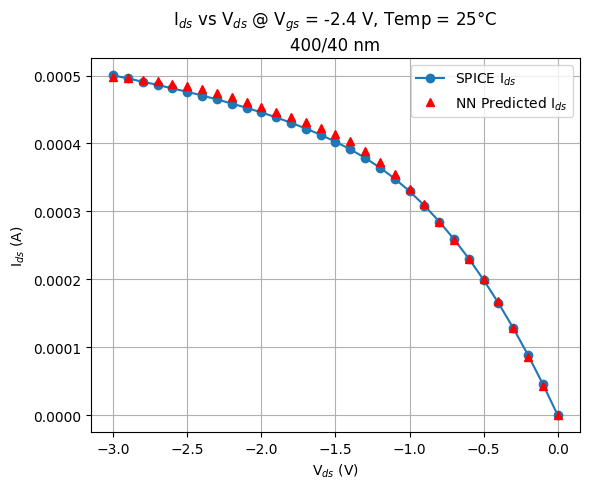

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


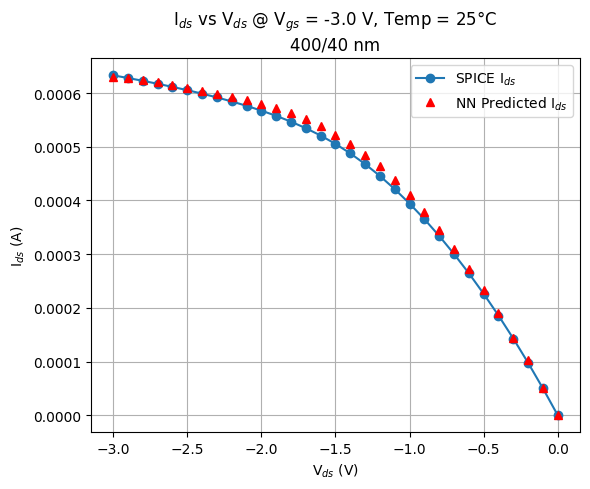

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


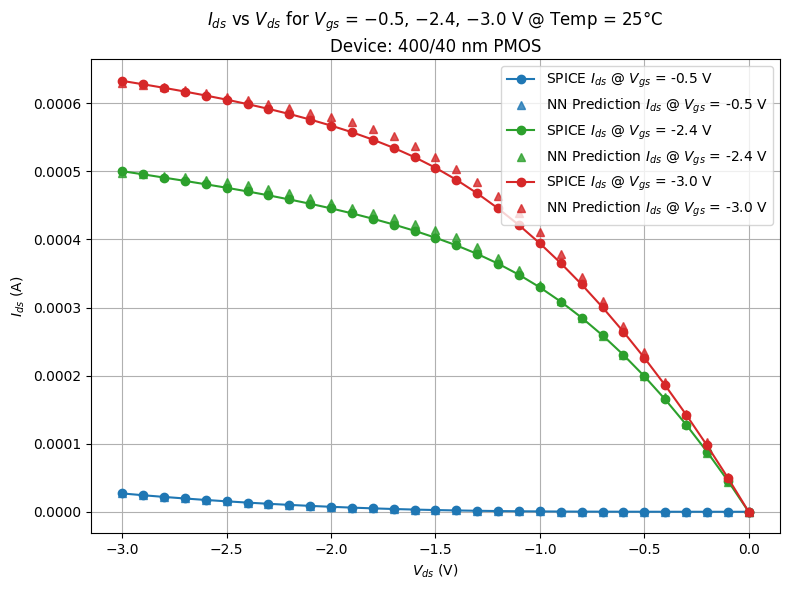

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 400/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


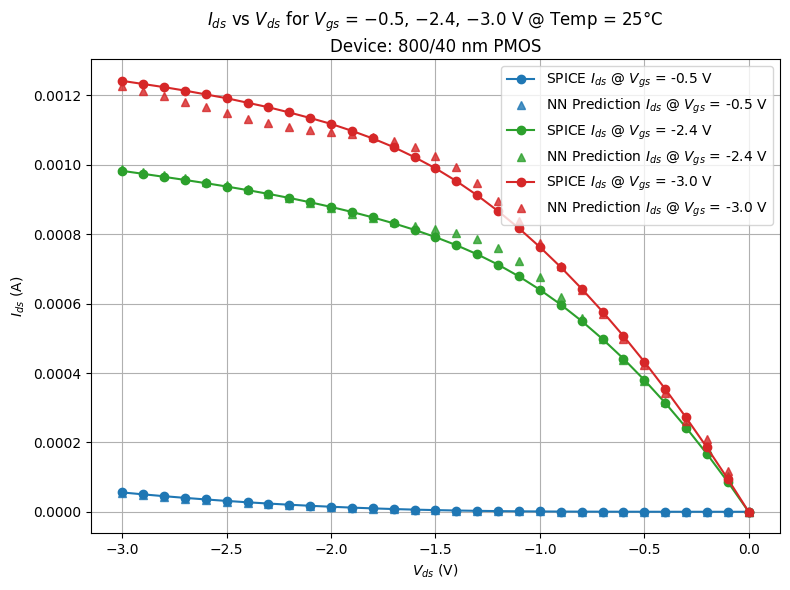

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


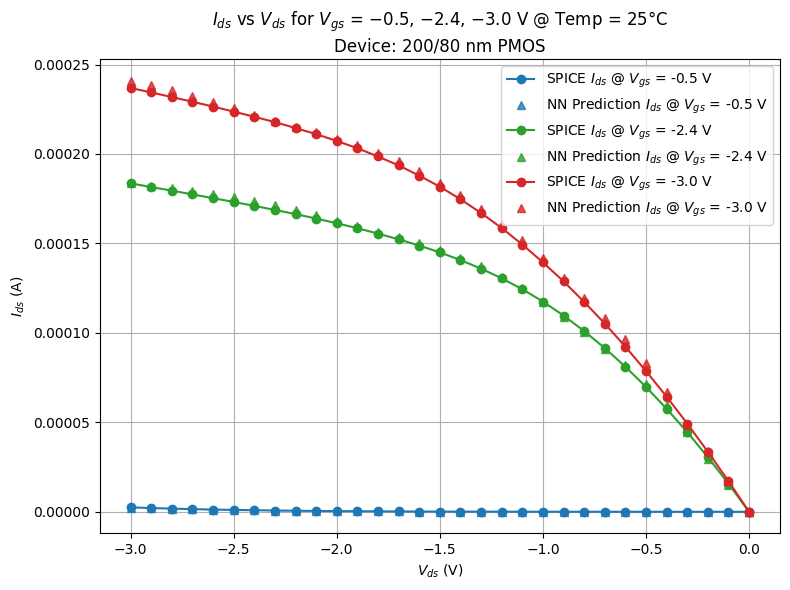

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


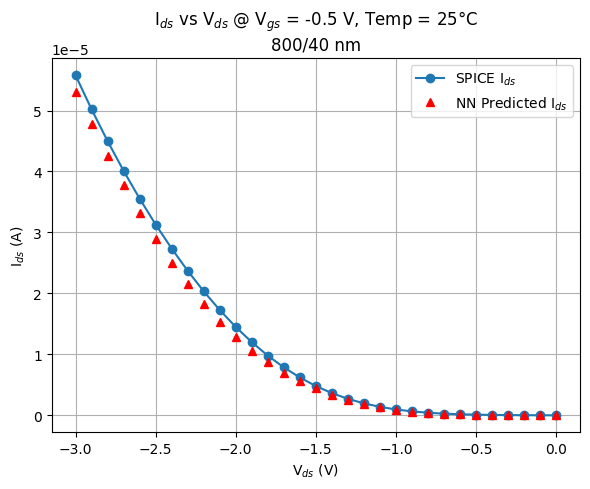

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


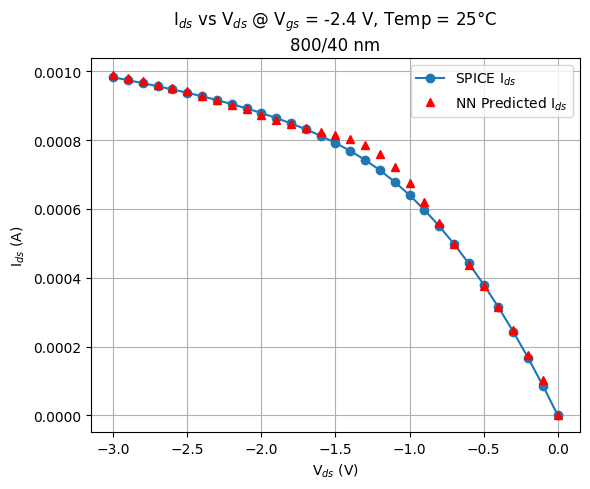

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


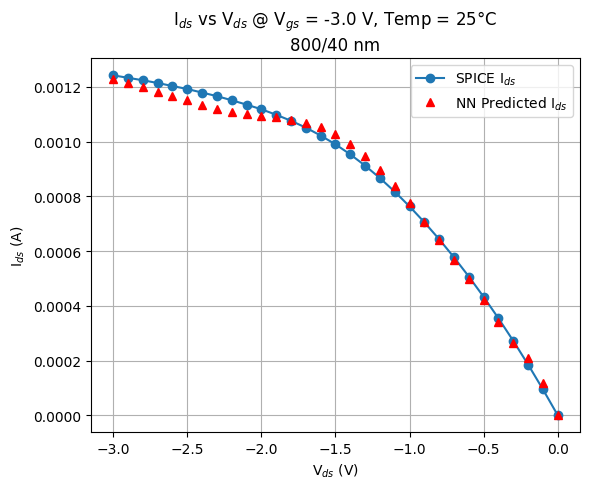

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


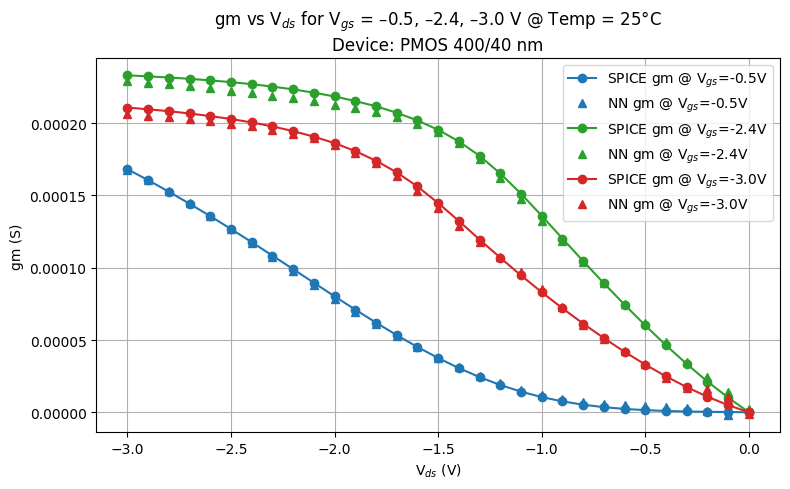

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/80 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

<Figure size 800x500 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


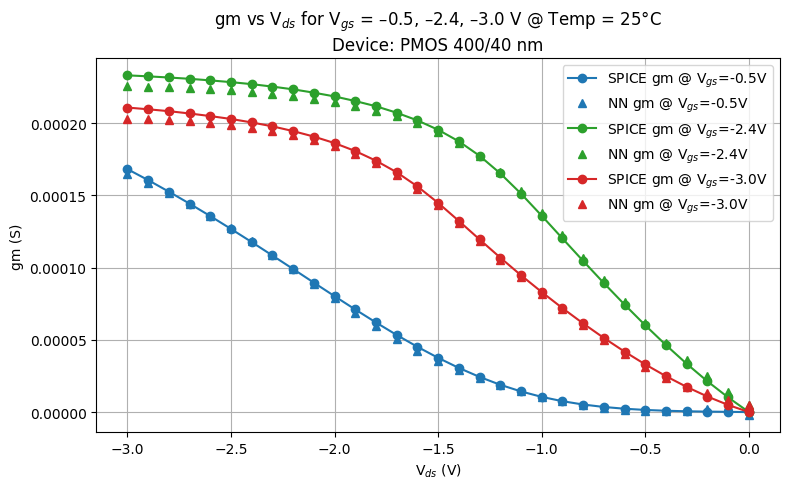

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


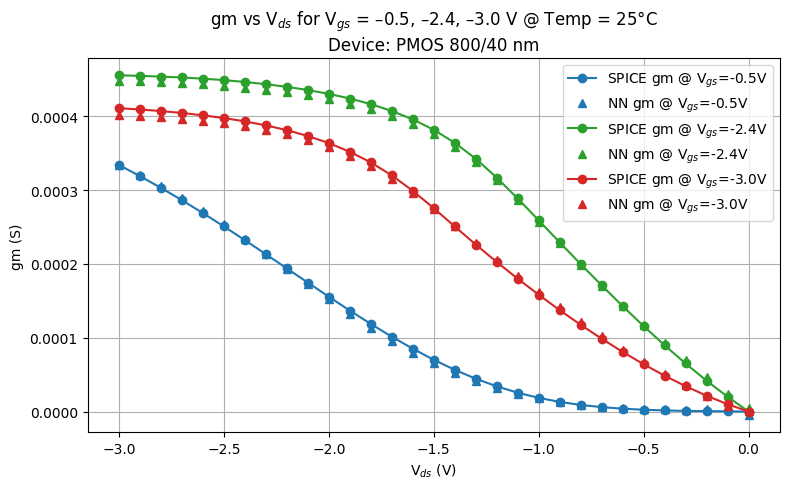

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


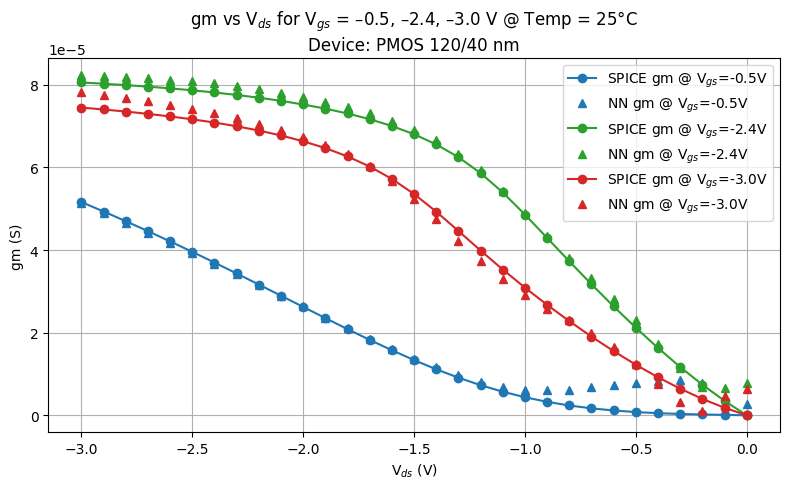

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 0  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 120/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


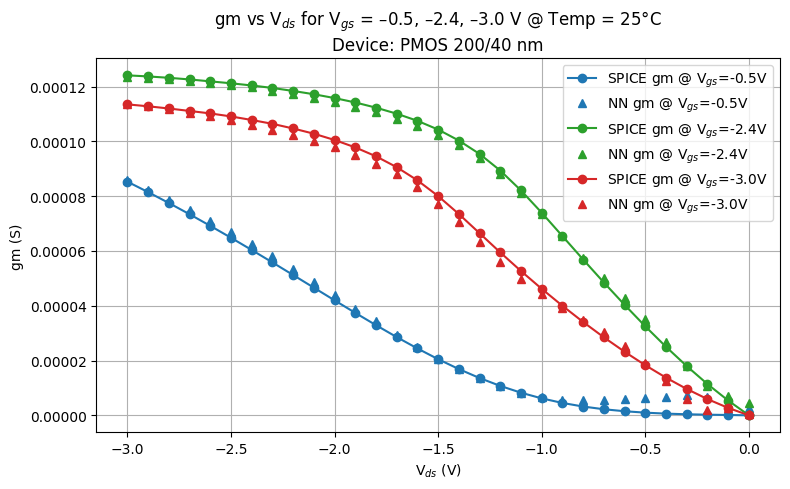

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


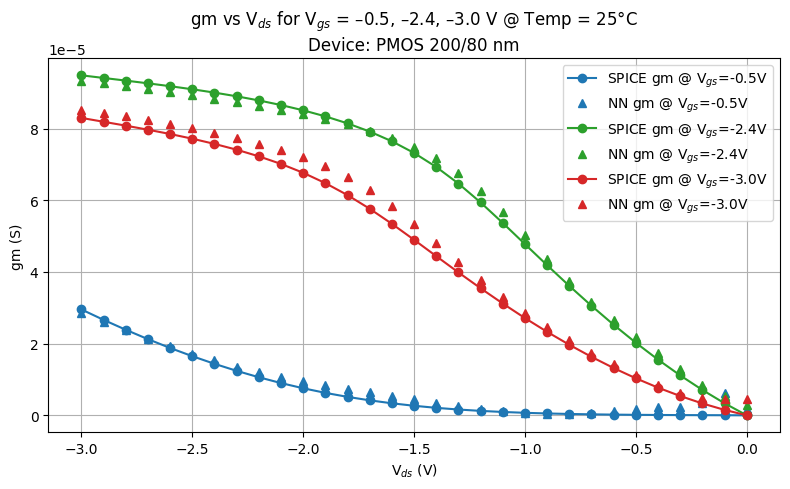

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 2  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/80 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

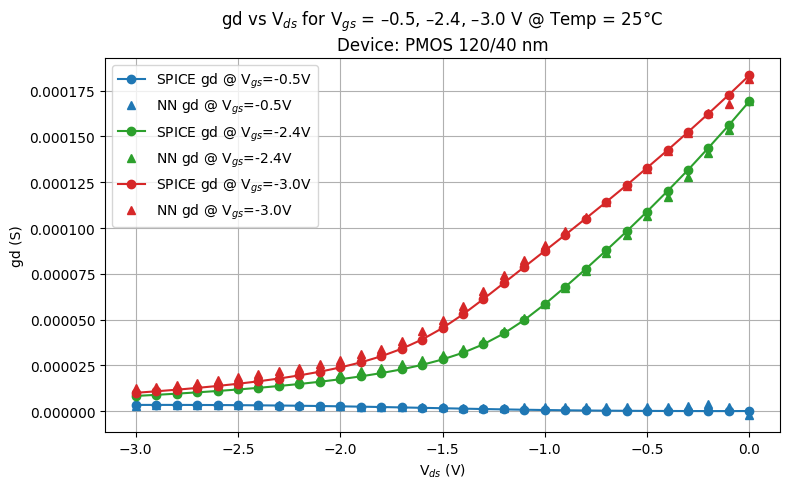

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 0 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 120/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

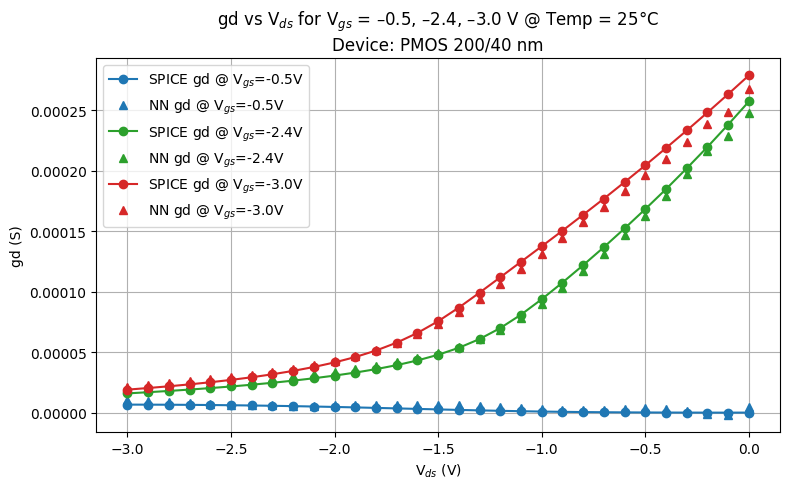

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 800x500 with 0 Axes>

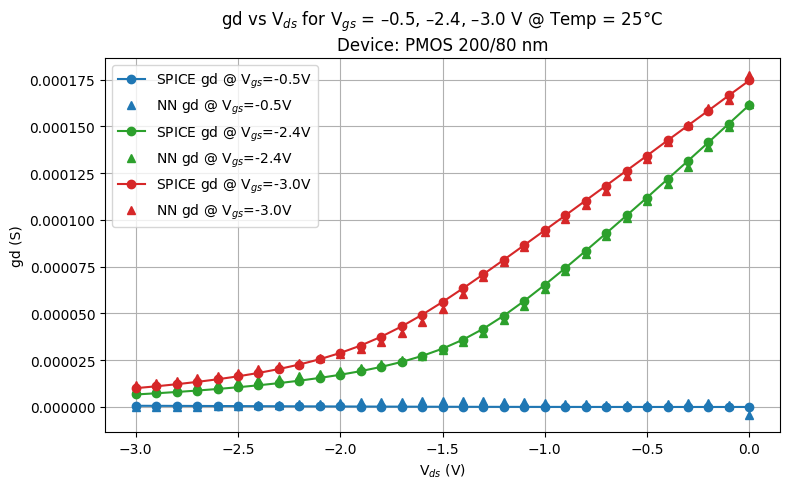

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 2 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/80 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<Figure size 800x500 with 0 Axes>

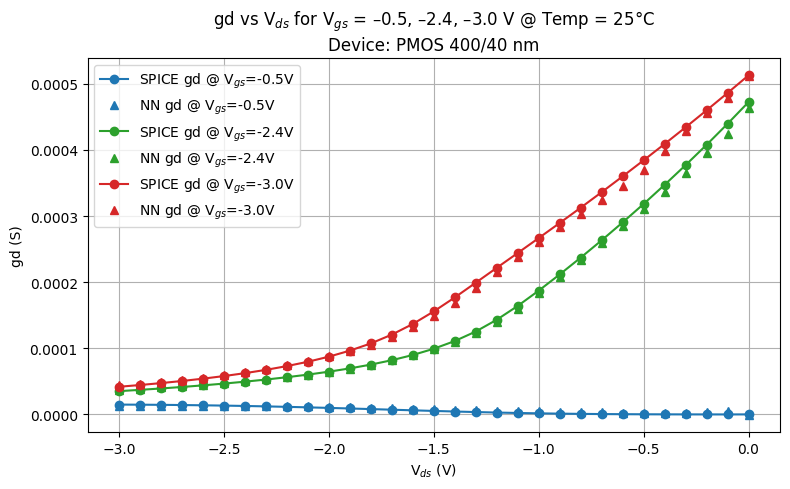

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

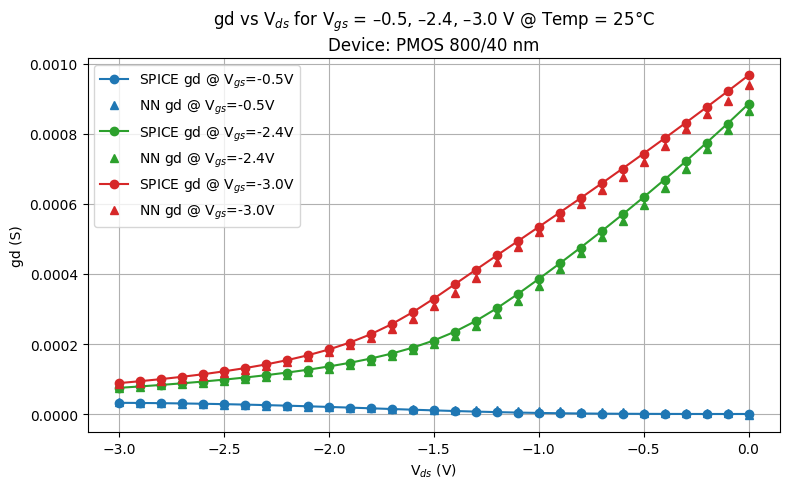

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


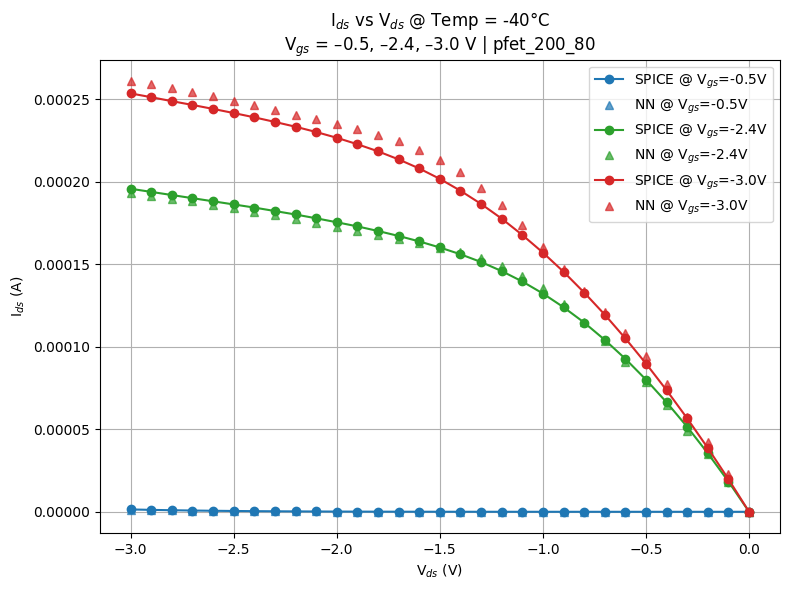

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


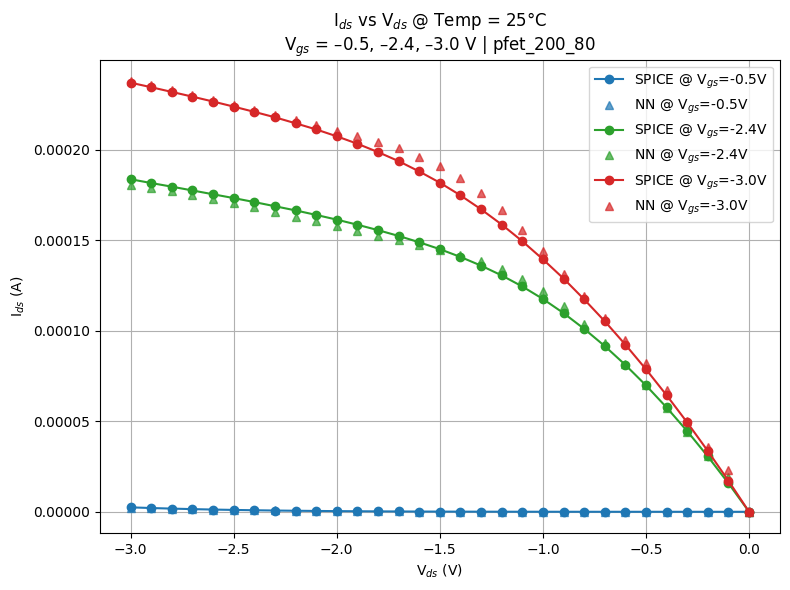

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


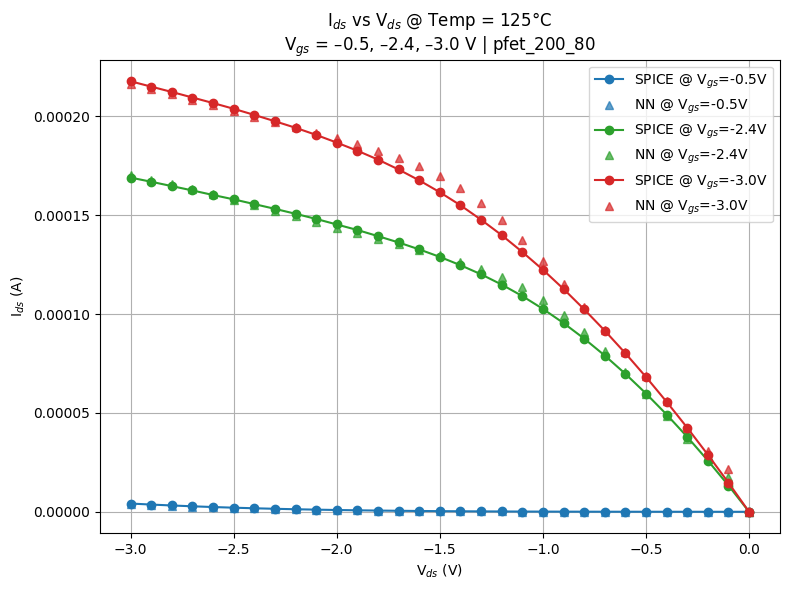

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


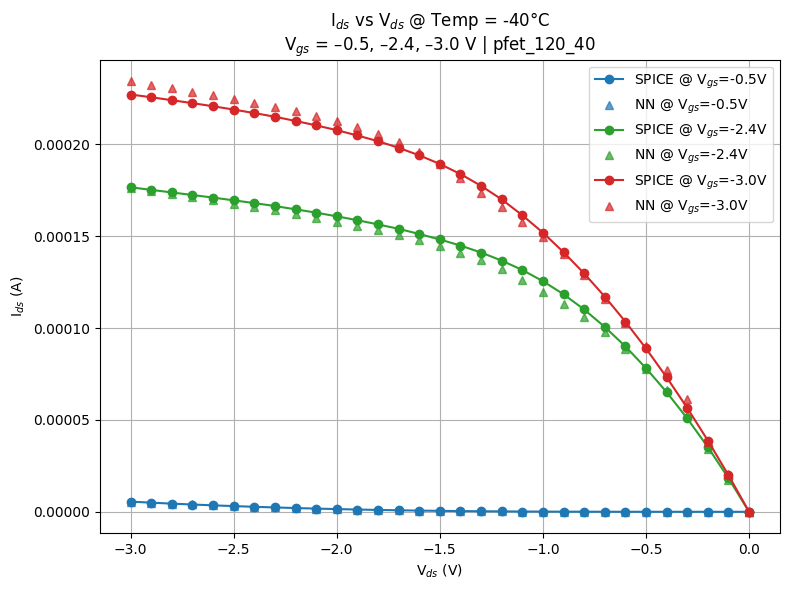

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


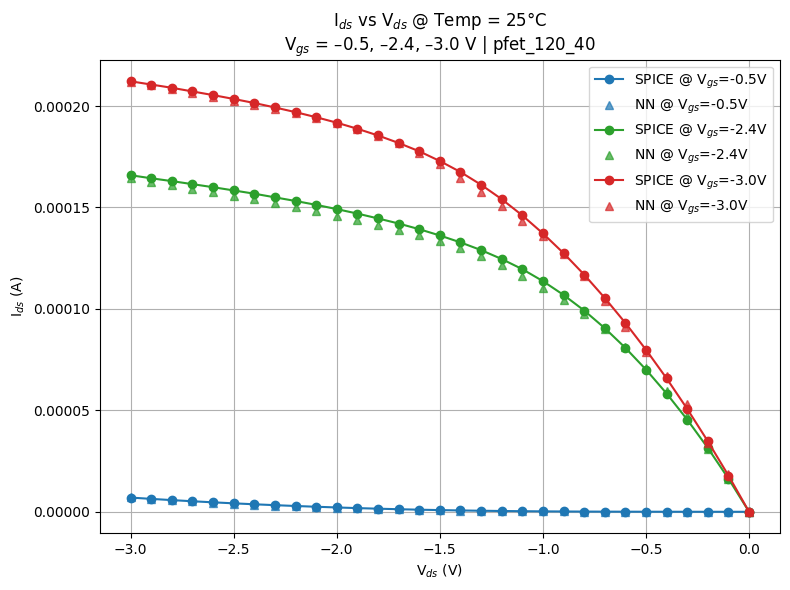

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


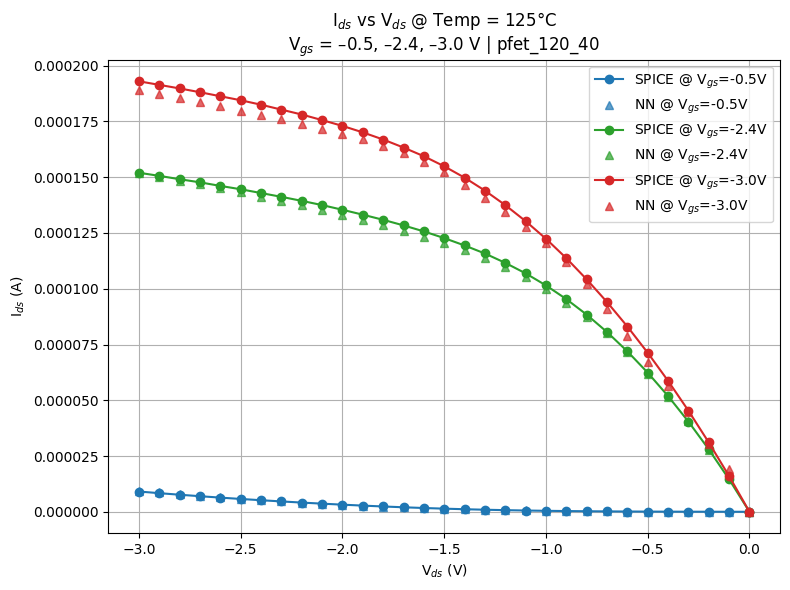

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


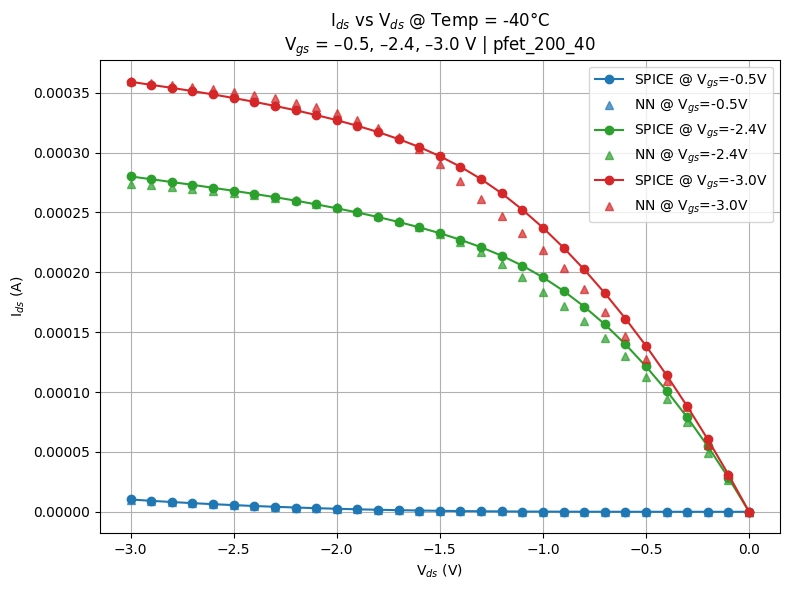

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


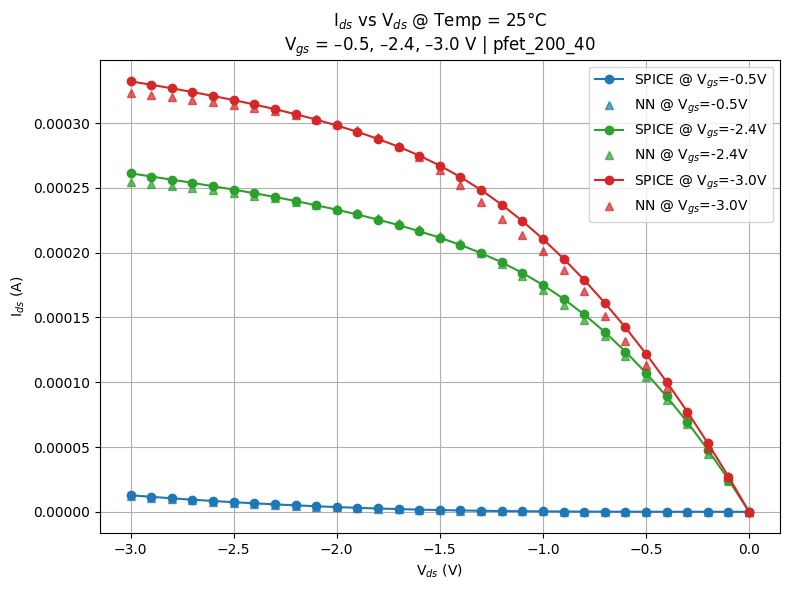

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


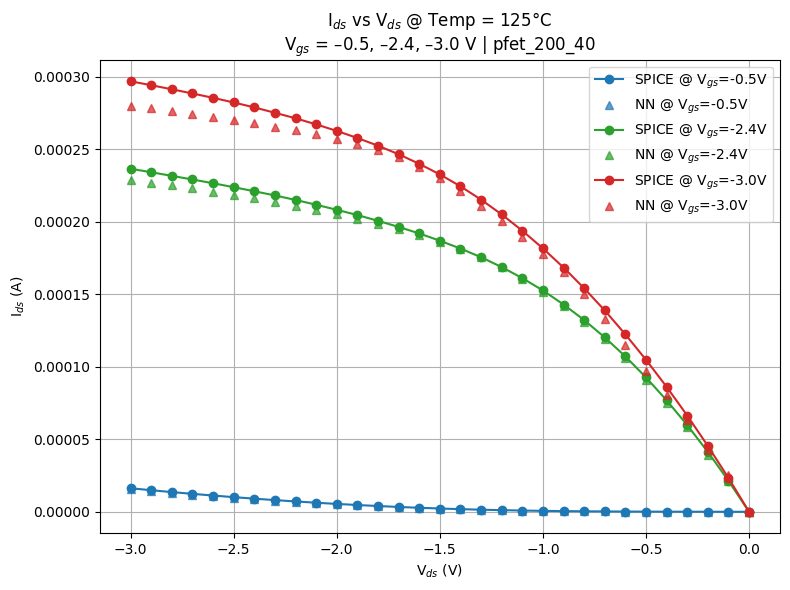

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


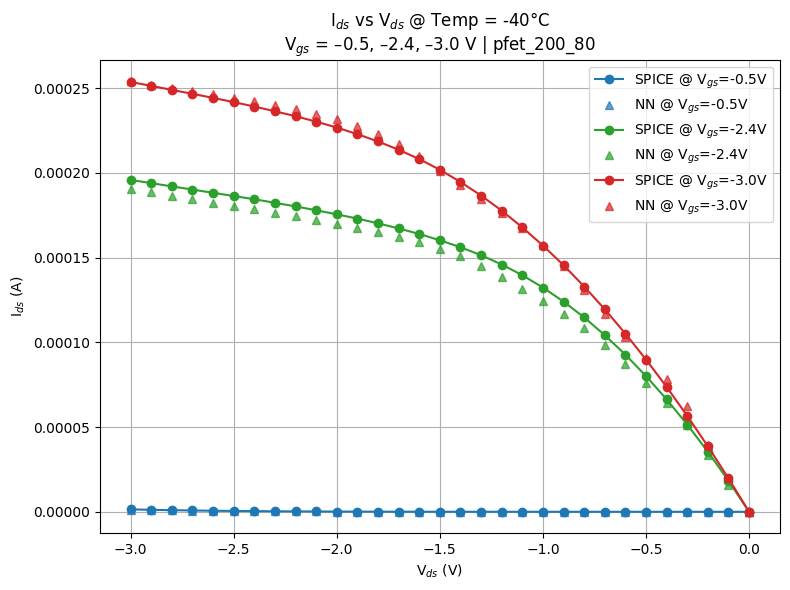

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


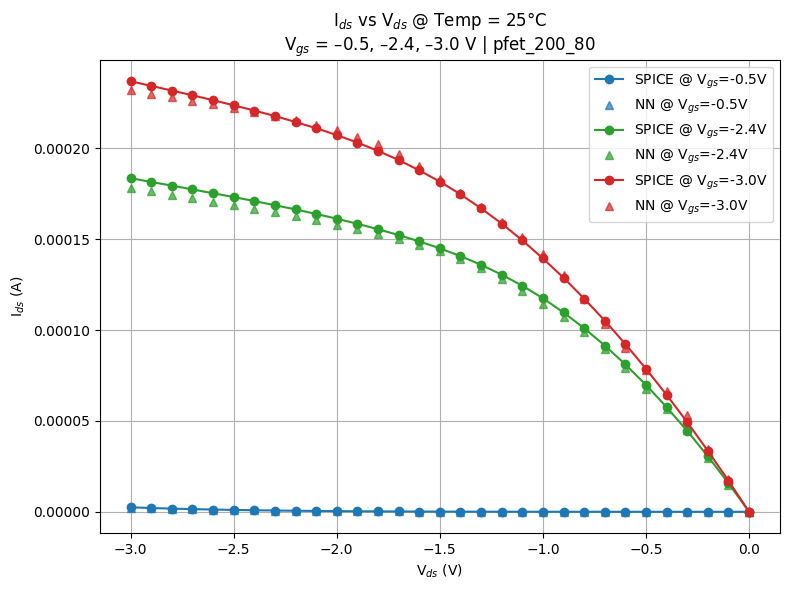

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


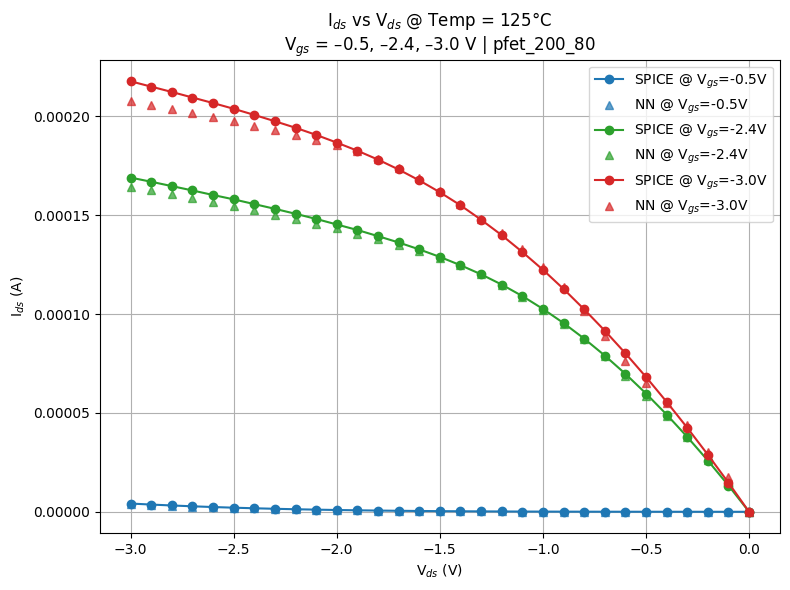

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


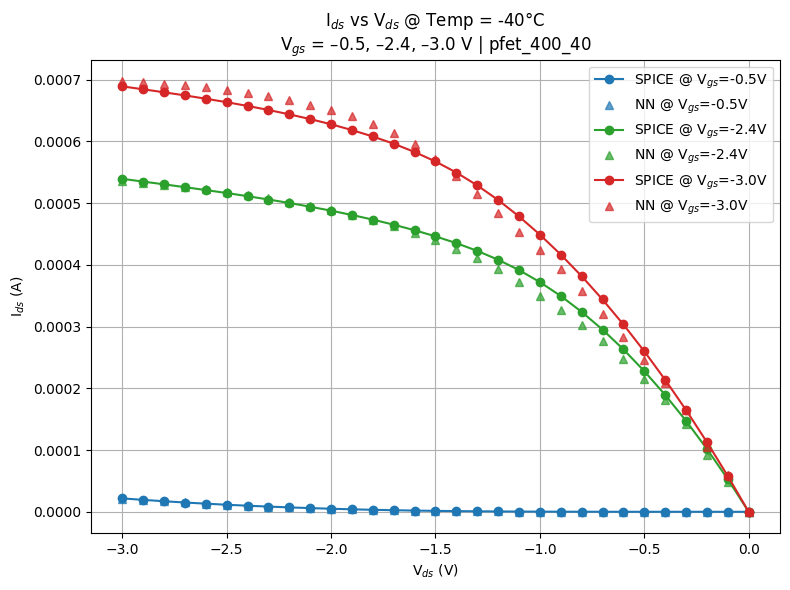

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


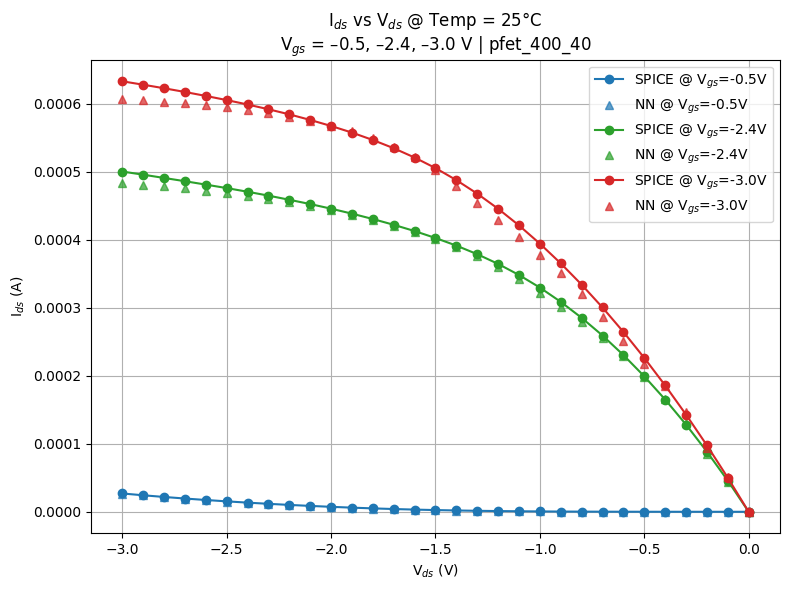

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


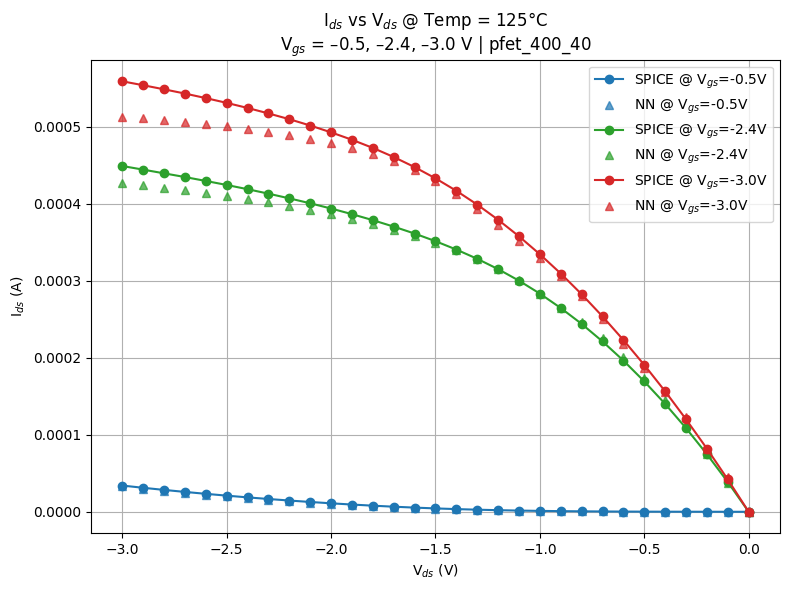

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


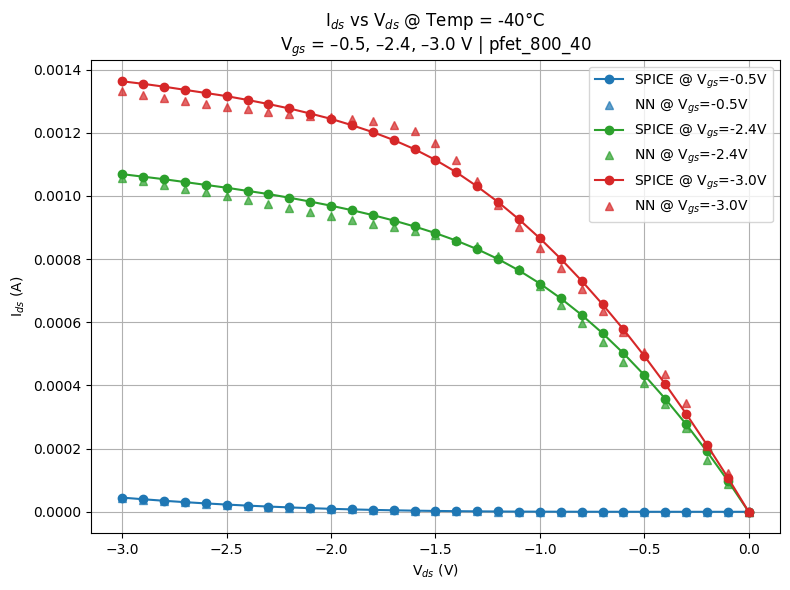

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


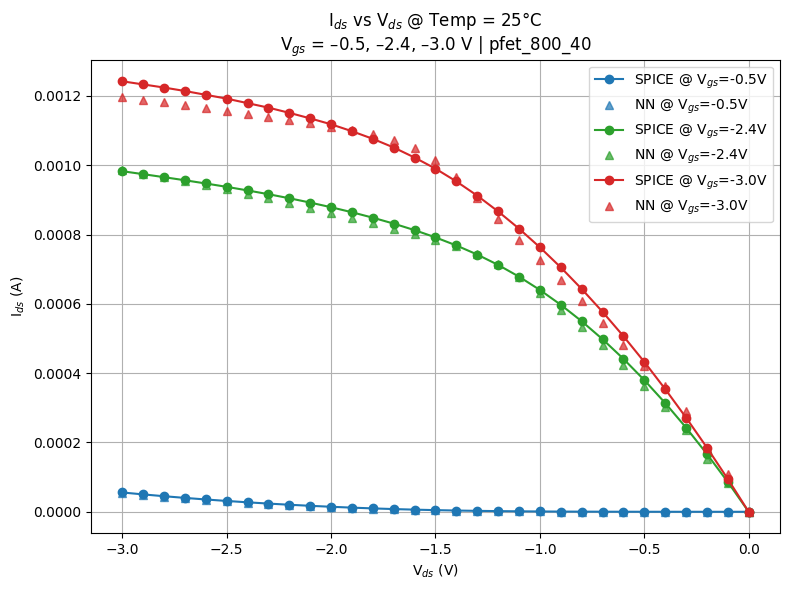

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


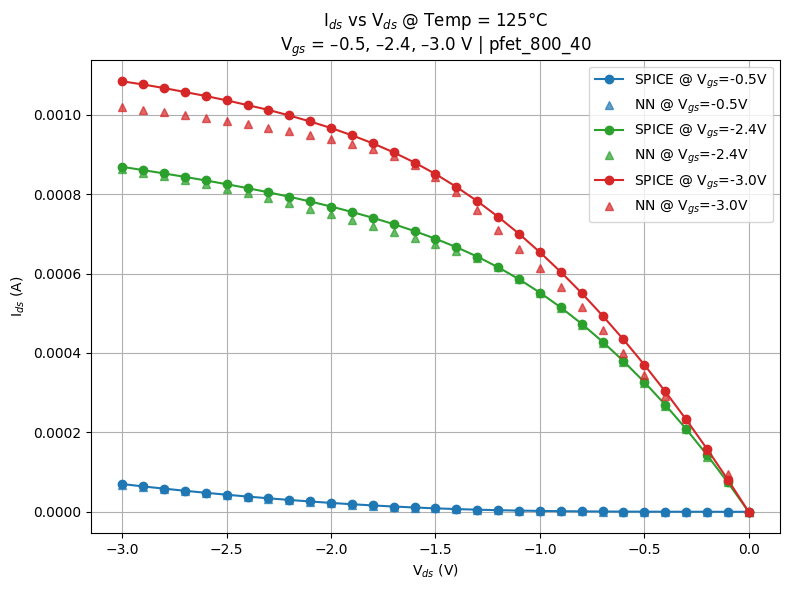

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


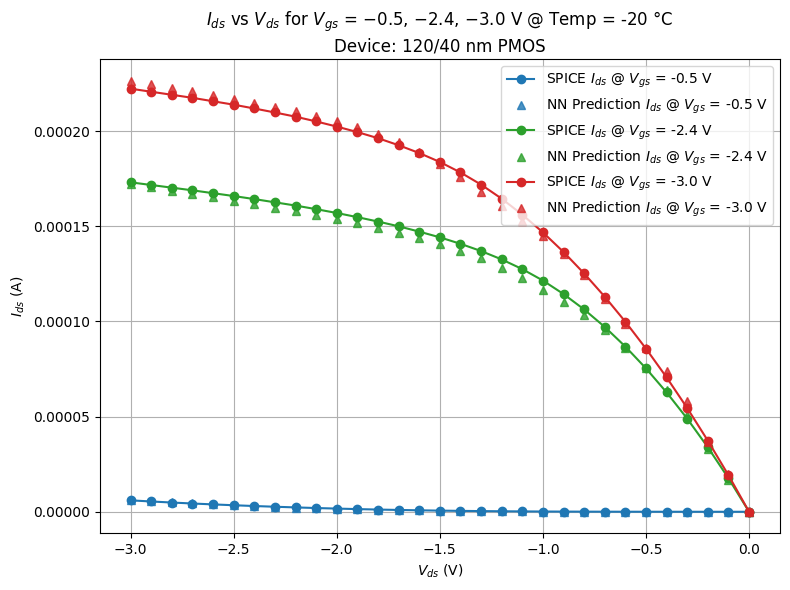

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


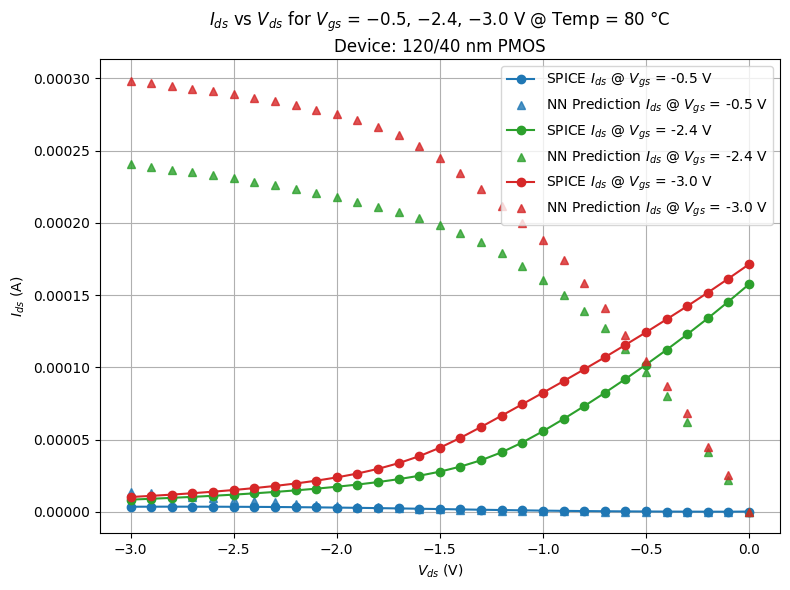

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


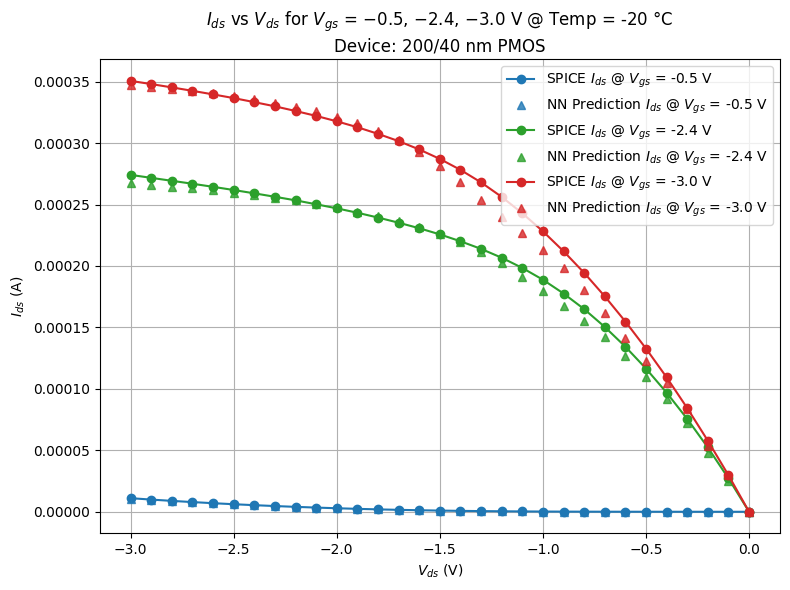

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


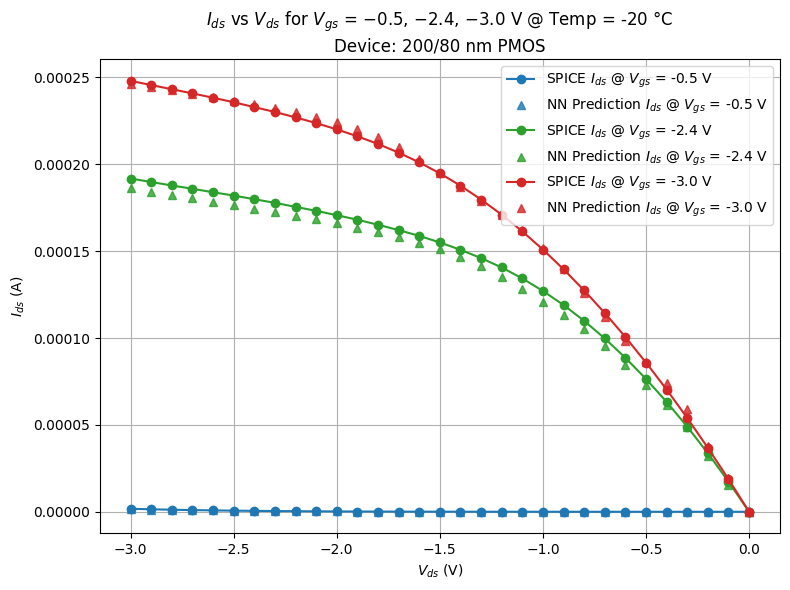

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/80 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


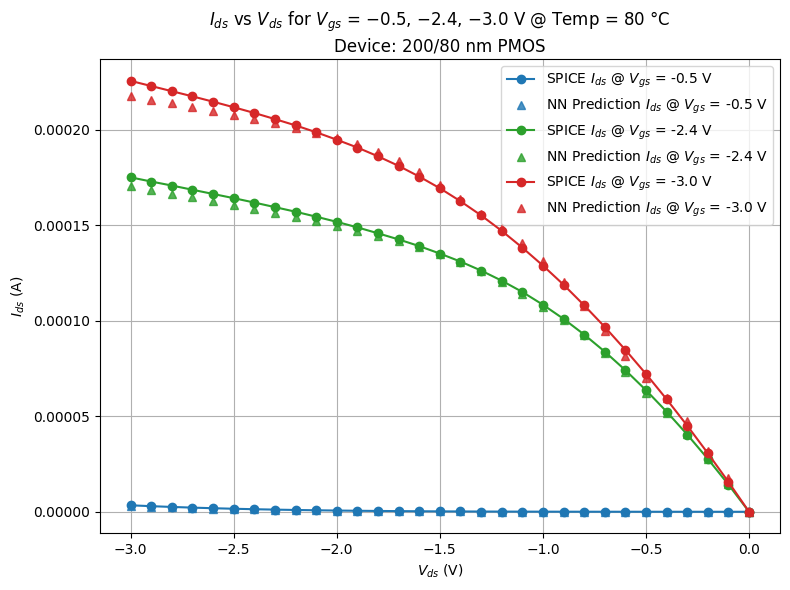

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/80 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


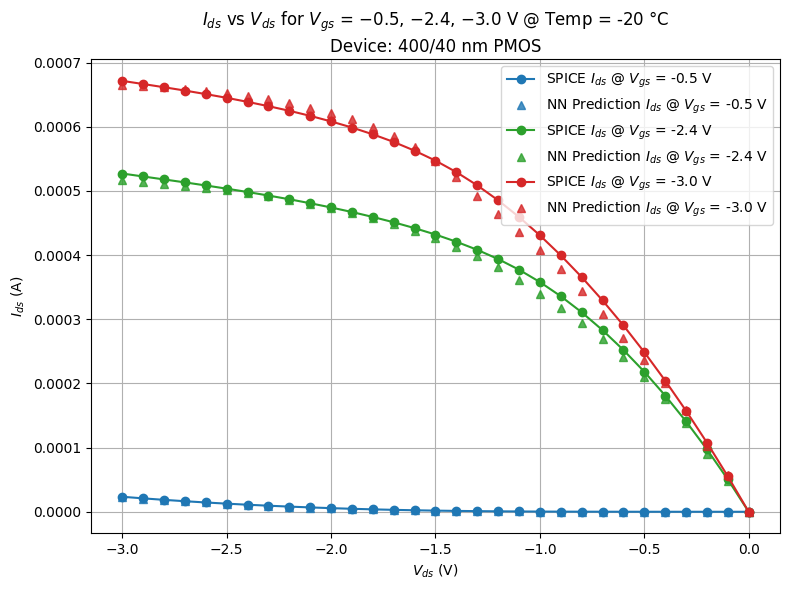

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


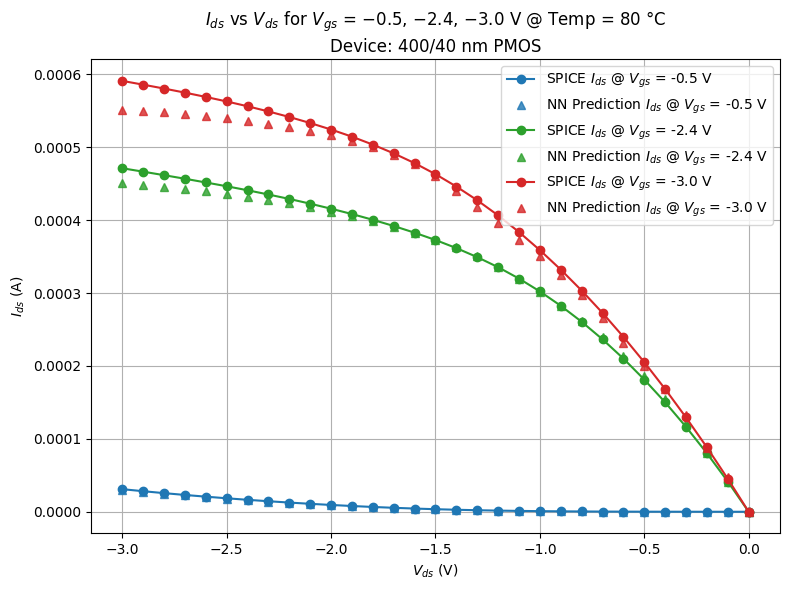

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


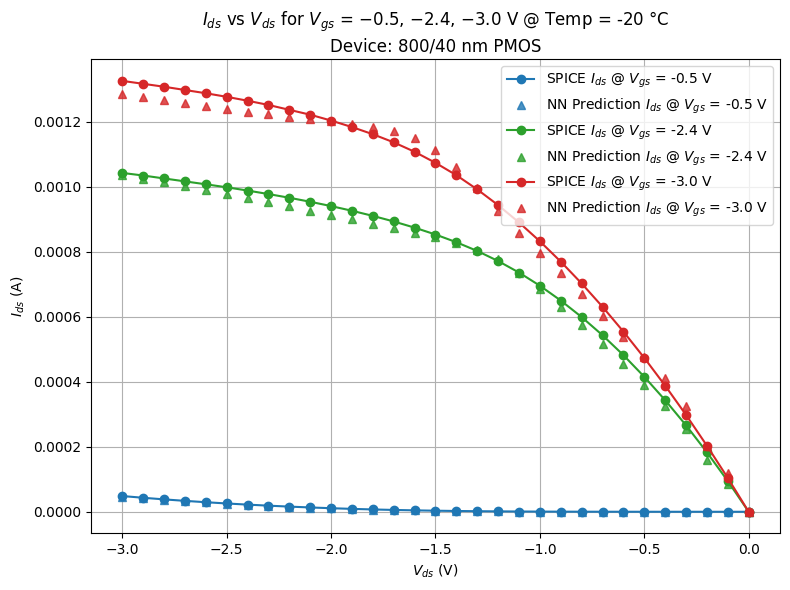

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


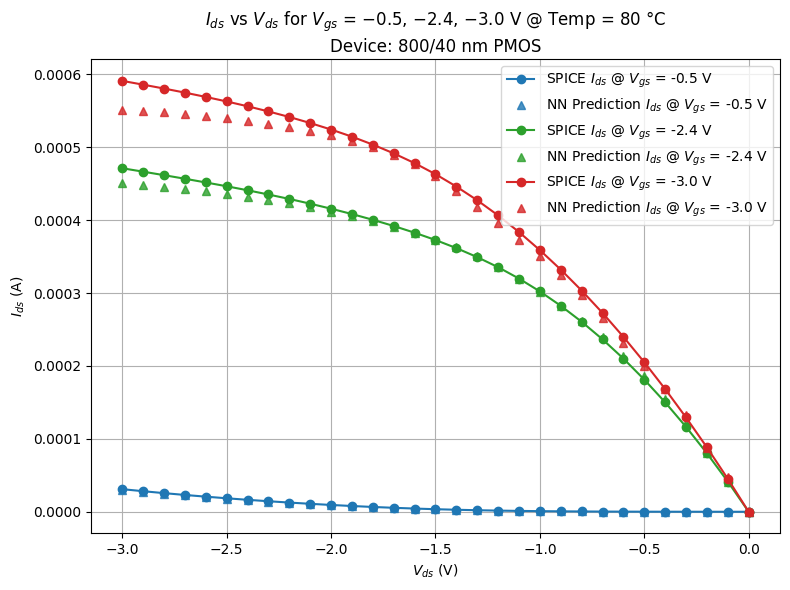

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


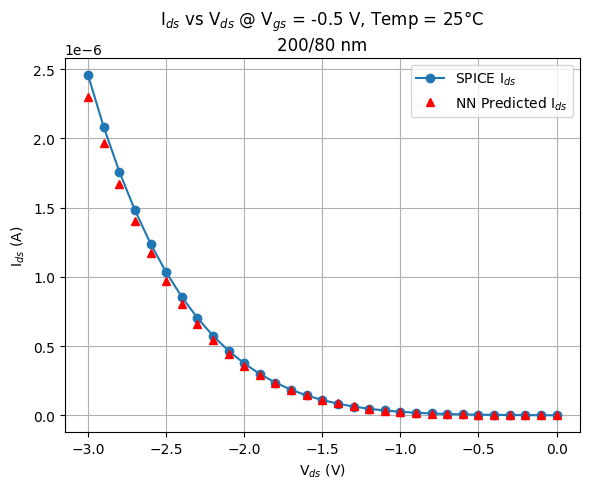

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


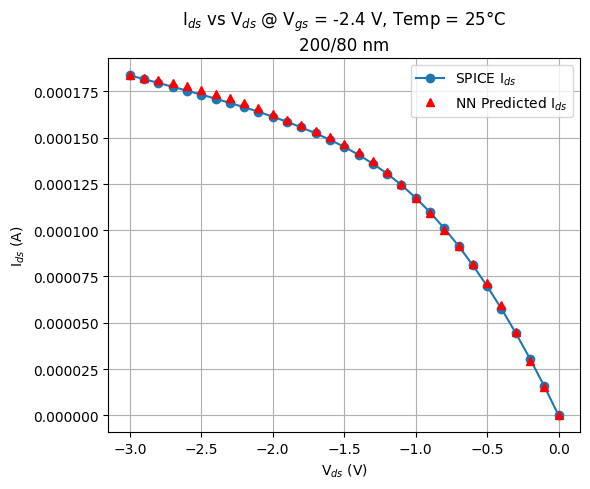

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


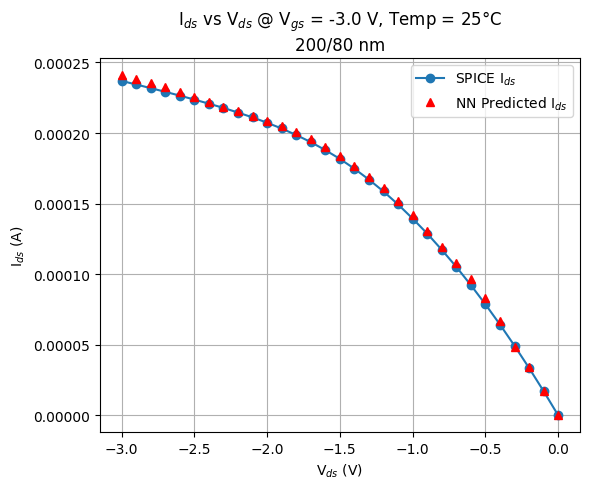

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


⚠️ No SPICE data found for Vgs = -0.5 V at 80°C
⚠️ No SPICE data found for Vgs = -2.4 V at 80°C
⚠️ No SPICE data found for Vgs = -3.0 V at 80°C


<ipython-input-29-309806f7c5c1>:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


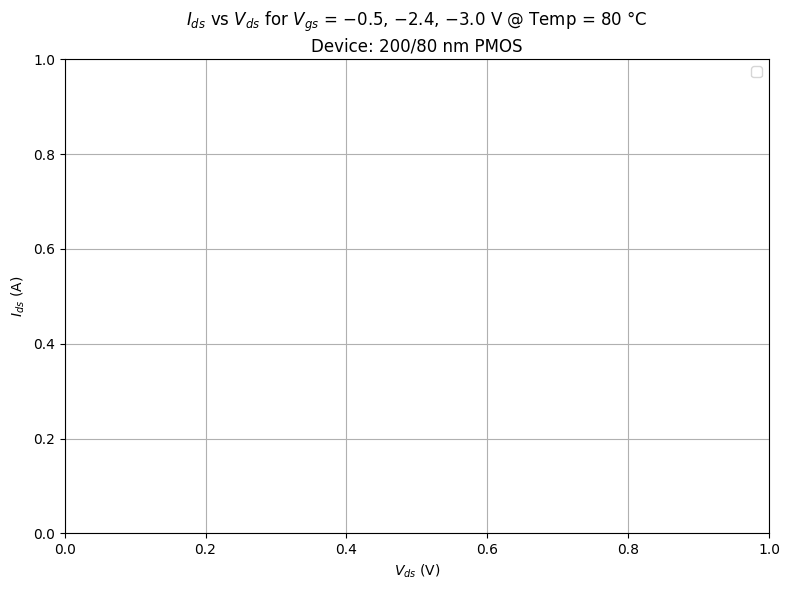

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/80 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
